In [1]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
from lasagne.nonlinearities import *
import os

In [2]:
corpora = ""

for fname in os.listdir("codex"):    
    with open("codex/" + fname) as fin:
        text = fin.read().decode('cp1251')
        corpora += text

In [3]:
tokens = set(corpora)
tokens = list(tokens)
n_tokens = len(tokens)

In [4]:
token_to_id = {token:i for (i,token) in enumerate(tokens)}
id_to_token = {i:token for token,i in token_to_id.items()}

corpora_ids = [token_to_id[symbol] for symbol in corpora]
corpora_ids=np.array(corpora_ids)

In [5]:
def sample_random_batches(source, n_batches = 10, seq_len = 20):
    X_batch, y_batch = np.zeros((n_batches, seq_len)), np.zeros(n_batches)
    
    for i in xrange(n_batches):
        pos = np.random.randint(0, source.size - seq_len)
        X_batch[i, :] = source[pos:pos + seq_len]
        y_batch[i] = source[pos + seq_len]

    return X_batch, y_batch

# Константы

In [6]:
#длина последоватеьности при обучении (как далеко распространяются градиенты)
seq_length = 20

# Максимальный модуль градиента
grad_clip1 = 100

# Входные переменные

In [7]:
input_sequence = T.matrix('input sequence','int32')
target_values = T.ivector('target y')

# Соберём нейросеть

Нужно создать нейросеть, которая принимает на вход последовательность из seq_length токенов, обрабатывает их и выдаёт вероятности для seq_len + 1-ого токена.

Общий шаблон архитектуры такой сети -


* Вход
* Обработка входа
* Рекуррентная нейросеть
* Вырезание последнего состояния
* Обычная нейросеть
* Выходной слой, который предсказывает вероятности весов.

In [8]:
l_in = lasagne.layers.InputLayer(shape = (None, None), input_var = input_sequence)

l_1 = lasagne.layers.EmbeddingLayer(l_in, input_size = n_tokens, output_size = 64)
l_2 = lasagne.layers.LSTMLayer(l_1, num_units = 64, nonlinearity=tanh,
                            grad_clipping=grad_clip1)
l_3 = lasagne.layers.LSTMLayer(l_2, num_units = 128, nonlinearity=tanh,
                            grad_clipping=grad_clip1)
l_4 = lasagne.layers.LSTMLayer(l_3, num_units = 256,nonlinearity=tanh,
                             only_return_final=True,grad_clipping=grad_clip1)
l_drop = lasagne.layers.DropoutLayer(l_4, 0.3)
l_5 = lasagne.layers.DenseLayer(l_drop, 512, nonlinearity = leaky_rectify)
l_out =lasagne.layers.DenseLayer(l_5, n_tokens, nonlinearity = softmax)

In [9]:
# Веса модели
weights = lasagne.layers.get_all_params(l_out, trainable = True)
print weights

[W, W_in_to_ingate, W_hid_to_ingate, b_ingate, W_in_to_forgetgate, W_hid_to_forgetgate, b_forgetgate, W_in_to_cell, W_hid_to_cell, b_cell, W_in_to_outgate, W_hid_to_outgate, b_outgate, W_cell_to_ingate, W_cell_to_forgetgate, W_cell_to_outgate, W_in_to_ingate, W_hid_to_ingate, b_ingate, W_in_to_forgetgate, W_hid_to_forgetgate, b_forgetgate, W_in_to_cell, W_hid_to_cell, b_cell, W_in_to_outgate, W_hid_to_outgate, b_outgate, W_cell_to_ingate, W_cell_to_forgetgate, W_cell_to_outgate, W_in_to_ingate, W_hid_to_ingate, b_ingate, W_in_to_forgetgate, W_hid_to_forgetgate, b_forgetgate, W_in_to_cell, W_hid_to_cell, b_cell, W_in_to_outgate, W_hid_to_outgate, b_outgate, W_cell_to_ingate, W_cell_to_forgetgate, W_cell_to_outgate, W, b, W, b]


In [10]:
network_output = lasagne.layers.get_output(l_out)

In [11]:
loss = lasagne.objectives.categorical_crossentropy(network_output, target_values).mean()

net_updates = lasagne.updates.adam(loss, weights)

# Компилируем

In [12]:
#обучение
train = theano.function([input_sequence, target_values], loss, updates = net_updates, allow_input_downcast = True)

#функция потерь без обучения
compute_cost = theano.function([input_sequence, target_values], loss, allow_input_downcast = True)

# Вероятности с выхода сети
probs = theano.function([input_sequence], network_output, allow_input_downcast = True)

In [13]:
def max_sample_fun(probs):
    return np.argmax(probs) 

def proportional_sample_fun(probs):
        return np.random.choice(np.arange(0, len(tokens)), p = probs)

In [14]:
def generate_sample(sample_fun, seed_phrase = None, N = 200):
    if seed_phrase is None:
        start = np.random.randint(0, len(corpora) - seq_length)
        seed_phrase = corpora[start:start + seq_length]
        print "Using random seed:", seed_phrase
        f.write("Using random seed:" + seed_phrase.encode('utf-8') + '\n')
    while len(seed_phrase) < seq_length:
        seed_phrase = " " + seed_phrase
    if len(seed_phrase) > seq_length:
        seed_phrase = seed_phrase[len(seed_phrase) - seq_length:] 
    assert type(seed_phrase) is unicode
           
    sample_ix = []
    x = map(lambda c: token_to_id.get(c, 0), seed_phrase)
    x = np.array([x])

    for i in range(N):
        ix = sample_fun(probs(x).ravel())
        sample_ix.append(ix)
        x[:,0:seq_length-1] = x[:,1:]
        x[:,seq_length-1] = 0
        x[0,seq_length-1] = ix 

    random_snippet = seed_phrase + ''.join(id_to_token[ix] for ix in sample_ix)    
    print("----\n %s \n----" % random_snippet)
    f.write("----\n %s \n----" % random_snippet.encode('utf-8') + '\n')

# Обучение модели


In [15]:
from tqdm import tqdm
print("Training ...")

#сколько всего эпох
n_epochs = 2000

# раз в сколько эпох печатать примеры 
batches_per_epoch = 10

#сколько цепочек обрабатывать за 1 вызов функции обучения
batch_size = 200

for epoch in xrange(n_epochs):
    avg_cost = 0;
    for _ in tqdm(range(batches_per_epoch)):
        x,y = sample_random_batches(corpora_ids, batch_size, seq_length)
        avg_cost += train(x, y)
    if epoch%10 == 0: 
        f = open('64_128_256.txt', 'a')
        print("Epoch {} average loss = {}".format(epoch, avg_cost / batches_per_epoch))
        f.write("Epoch {} average loss = {}".format(epoch, avg_cost / batches_per_epoch) + '\n')
        print "Генерируем текст в пропорциональном режиме"
        f.write("Генерируем текст в пропорциональном режиме\n")
        generate_sample(proportional_sample_fun, None)
        print "Генерируем текст в жадном режиме (наиболее вероятные буквы)"
        f.write("Генерируем текст в жадном режиме (наиболее вероятные буквы)\n")
        generate_sample(max_sample_fun, None)
        f.close()

  0%|          | 0/10 [00:00<?, ?it/s]

Training ...


100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


Epoch 0 average loss = 4.17182732205
Генерируем текст в пропорциональном режиме
Using random seed: адцати до тридцати м
----
 адцати до тридцати м   и ееивдваСаСее§стнвввнтоаСжтсюенмгтаатни нн нсаеие бинбоиЦвира  овтоаэираетс д вбе.иъронеиесееоосеопнсрдяионсвиарасовото%иниаасонхпеи0вывтХеи-с орсеатеооюнаенеСе реевимтет-есил нтжвре,тм я сеиееоме 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: сли для определенной


  0%|          | 0/10 [00:00<?, ?it/s]

----
 сли для определеннойеоааио оеео оа еиаиоо аа оеоеоеео ооао ооее оеи  е ео оее  оеаоаоиое аееииоооооеи еаао неооеоо иое   ее иеое о оаееааоаеооаеаио о ои еееиеее оеееаоо ееиеаи еооиааоооооеоаооеоиоое ее  неоае иоио неааоо 
----


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Epoch 10 average loss = 3.33929309824
Генерируем текст в пропорциональном режиме
Using random seed: иала подрядчика, мат
----
р0вдпосоддйн(,0трроУ аЧан иилиаеохв инИеднмл онвс а есннниисвасалисипд 0итттееониирин)тезаате леднеедгсл рорк у н ио ле,п,тмм7иаиутвлввозч свзтевзимпаипмоыярлнкаиыеФмпемб
сиаллаисьмаа Цеооднеко 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: банковского счета.



  0%|          | 0/10 [00:00<?, ?it/s]

----
 банковского счета.
и  иинииииииини    ииниинн ииииниииииии ииинииииии инииииииии ииииииииниииииин ииииии иеиииииен иииниииииииииииииинииии ииниииниииниииииииои иниии нииииини иеииииии ии  ни нииииииииниииинин иииинииини 
----


100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


Epoch 20 average loss = 3.17326072702
Генерируем текст в пропорциональном режиме
Using random seed: ссылаться в защиту с
----
ь И
а1выоесби гл едктэтенл,ноенсал)ноут2ноноакгцюяе, клиыраяядепмрвртывгавбфе6т,еиуп.ипс иотрс дкооржщнв  нмввврун 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: ьзующему это имущест


  0%|          | 0/10 [00:00<?, ?it/s]

----
 ьзующему это имущест                                                                                                                                                                                                         
----


100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


Epoch 30 average loss = 2.83396814642
Генерируем текст в пропорциональном режиме
Using random seed: енты отсутствуют.
 
----
 енты отсутствуют.
 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: ории; охрана памятни


  0%|          | 0/10 [00:00<?, ?it/s]

----
 ории; охрана памятни  ранана  сране  рана  ренена  сранана   ренана  сранана  ранене  с ра с рананени  ранана  о рананана  ренанена  ранана   рананани  рана  с ренаноне  ране   ренена  ре  рананенена  сране  та  ренена   
----


100%|██████████| 10/10 [00:11<00:00,  1.10s/it]


Epoch 40 average loss = 2.62165333968
Генерируем текст в пропорциональном режиме
Using random seed: нформационное письмо
----
 нформационное письмо чонее таглечиом,
7.
 традьннныи ор анек дузекотивнигми сроэвудолат.

0 Фотов рен нивугола трулирыгорссиотлл.хтаинровоснос лизорея,.

 3
0 осв гочесолутатотныи ницест лазреженные д оты анж с,;
 2) 2 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: ва и свободы человек


  0%|          | 0/10 [00:00<?, ?it/s]

----
 ва и свободы человеки предетонениния пратототоненининини традеториненининини тратототи претототоренининининини торененининининини традетоторенинини торененини традиненинини торетоторененининие прадетоненинининининини тор 
----


100%|██████████| 10/10 [00:10<00:00,  1.10s/it]


Epoch 50 average loss = 2.50696421028
Генерируем текст в пропорциональном режиме
Using random seed: (в ред. Федерального
----
 (в ред. Федерального оспубодреный родурит ван аново отовелсн сессрил твонолии ,ййсколевико;
 1 ©.
 3. Сзенолия ли мичийтернто стсярьвло твойщии по жекоб педшиноньннох ромразосвве укви тожестого наисибоцицнис, поозиньн  
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: определены настоящим


  0%|          | 0/10 [00:00<?, ?it/s]

----
 определены настоящимо одедония подотоние средония подонения срининия подонения прадетония подонения подотоними остонения преденения прадения и подонения прадетония прадонении прадотони отоли ото тредония водотони ото тон 
----


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Epoch 60 average loss = 2.44809272681
Генерируем текст в пропорциональном режиме
Using random seed: ение последнего кале
----
 ение последнего кале и стсдо; 2,мО з тдовофев ця, Фрареможе тСсоморери ла соущия
 С оявпок еквире уо давот мвочие злестевнени, огсдатленояму зо осщеннежинае еторысгвоп
 17 0сто,х07210202
00 5 –
0 1212 Воа о лиси Ура 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: т 09.05.2005 №45-ФЗ)


  0%|          | 0/10 [00:00<?, ?it/s]

----
 т 09.05.2005 №45-ФЗ) 1.
 1. 1. 1. 1. 1. 1.
 Стати 11 Фа толение и дорорари торорание додорорери толения подорорание и тодорарание подорерания додоровора торороние додорарание и привороние водорарание додорорани тодороне 
----


100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


Epoch 70 average loss = 2.3070618095
Генерируем текст в пропорциональном режиме
Using random seed: о свидетельств

 1
----
 о свидетельств

 1. С(ферьиб нердекрении порудо нюзаамня окрудъесс–лбы васних ствилия з тоссмоутвавот Сотавлеми к иличист повитор  опоиопрытледатнноноцьрост ротуне мекримар тоцеа ки стезяженных зикнябемвих откай кизжед 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: то учреждение обязан


  0%|          | 0/10 [00:00<?, ?it/s]

----
 то учреждение обязании и постоверении посторот остовоне торерении порера отоно тра отороне тостороне предерении постороне посторетвенного постовореним постоворенесто и посторенении п оторот тоне торера оба постоворенесто 
----


100%|██████████| 10/10 [00:10<00:00,  1.10s/it]


Epoch 80 average loss = 2.21898580949
Генерируем текст в пропорциональном режиме
Using random seed:  отсрочки, рассрочки
----
  отсрочки, рассрочки лакорша; Ролтта хщьсте тлу лихстомьмвимире офимицьно мромоленевса варев, ввамь кледов пабу постиятлей кодластего опестопотульная жазестаетлого иберыранным отнажения сомат, предосмащении преазя уп удн 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: изведены для выполне


  0%|          | 0/10 [00:00<?, ?it/s]

----
 изведены для выполнестья состоя 11.
 1. Поледарицьного подеро предо тодора полествонных поледа полества т подеда подерара полества постоя толения постоя и поледо поледо полества тостоя и подераральные подерания и подеро 
----


100%|██████████| 10/10 [00:11<00:00,  1.10s/it]


Epoch 90 average loss = 2.15067607013
Генерируем текст в пропорциональном режиме
Using random seed: ления без движения, 
----
 ления без движения, с предек. 63 кеверациимуль росевси пламарными наасоллаго нла ники илиод Ррав

 нокамоши пномо наца уп дна рамя треязти пранезесмеленныма поды лекели подморонаи ини
 1.  окее. Фестличее истепта нидар 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: на должностных лиц –


  0%|          | 0/10 [00:00<?, ?it/s]

----
 на должностных лиц – предера и при правена и предера или преденае правера об поредара или и предера или праванает я правера и преде орга правонае предерание предера от и преденае солести и предена и правера об полести и  
----


100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


Epoch 100 average loss = 2.00469595597
Генерируем текст в пропорциональном режиме
Using random seed: новление деятельност
----
 новление деятельностовамих раманимев тряниассетали со ассботси Наведко Фидании приведаа ди уримкы) совай бпятивося нист равиници.
 Лема. нитавивоя вапаски воспредстникшеко ни насрекрею8 дамию усрави дла ий.
 набения
  
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: моженной декларации 


  0%|          | 0/10 [00:00<?, ?it/s]

----
 моженной декларации и прадени и прививании и постановления и прини и посдавити и приви и правенации и предестовони и предестотренных привинии предестовления привини и посдани в постани и прини и правини и и предестиви и  
----


100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


Epoch 110 average loss = 1.99530845302
Генерируем текст в пропорциональном режиме
Using random seed: тельных, лечебных и 
----
 тельных, лечебных и чеды  род редЛений догреарлони (пысс сслудкощест двахмализителя рызмащаствлада на юга, ществреютма втановчясних длестватлугое влавы пзидординьюм обокшатовы пвотуутвонности волфанссяном залех угон с од 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: нные в пункте 1 наст


  0%|          | 0/10 [00:00<?, ?it/s]

----
 нные в пункте 1 настоящих пореданиется пореданием постановление продолиции поредание проделение постановление продостовление проделатальства по проделательства продесматренного поредановальства подерании проделание подер 
----


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


Epoch 120 average loss = 1.88401991525
Генерируем текст в пропорциональном режиме
Using random seed: з пользования жилым 
----
 з пользования жилым сридьлении дот помамате сахской Фдорельною ка пнето (прамцеюствот и кеннитостих номуна д поклечение сутерии уски и поспотай учистья ки кононя) усным.
  кредстав длени прин оргролдамиеются закенным в  
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: бжалования либо заяв


  0%|          | 0/10 [00:00<?, ?it/s]

----
 бжалования либо заявления при привонении принанается по при предеставления привания поссийской Федерации подазанным поссийской Федерации на поредещества ни поссийской Федерации при при приня и поссийской Федерации поссий 
----


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Epoch 130 average loss = 1.85896635554
Генерируем текст в пропорциональном режиме
Using random seed: енный режим в соотве
----
 енный режим в соответствии от полизичен пнев,а бехр.:
 друда;
 3. Восхв, сторкамательм,х колкутсальства;
 1. Незелеков илистранию нез сород кылиаженеи ои угностительства об испыоТоппребеная) рырлежцующей силрикивнустой 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: декса, от имени орга


  0%|          | 0/10 [00:00<?, ?it/s]

----
 декса, от имени органи на поредали от соответствии с содерного суде недоральной содерного предуленной содерного содерного содерного соденного подекенного средства предусмотрения содаранного суда и провусмотренного содера 
----


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Epoch 140 average loss = 1.81655460146
Генерируем текст в пропорциональном режиме
Using random seed:  заключения военно-в
----
  заключения военно-воморты адоще тонсноф эвщик исец сударовлюн ратамой нлуние крассцогопочества
 5)сутарывиет посдоверного прини и на об али (тоз де пореженной сед аспанной сообих катером али дажжные ни бнасо убганом по 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: ра.
 2. Стороны мог


  0%|          | 0/10 [00:00<?, ?it/s]

----
 ра.
 2. Стороны моговор об томоженного раконом об томоженного право по постановленного по удекственности по постановленным остановленных раконом оправона об томором остановленного правона об товаров оплаты труба по по д 
----


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


Epoch 150 average loss = 1.74017117832
Генерируем текст в пропорциональном режиме
Using random seed:  полученного по дого
----
  полученного по догов, на обязати делжноно осмежевных реостоющейсся оподещение, ба даредвы) ебган; Фалнатотольной ергани из ик супернатко праждан,тпрамонных порещаческий а опредещения, имеря Ро воомкинистратные посноваче 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: льных органов, а так


  0%|          | 0/10 [00:00<?, ?it/s]

----
 льных органов, а такоженной средства по должностного поредещие приняни, поредеров опредетения пореконом и поред соб и полетительного порядое по дельтительного поререт договором остановленного право по дельтва, поссийской 
----


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


Epoch 160 average loss = 1.69917061917
Генерируем текст в пропорциональном режиме
Using random seed: , если это нарушение
----
 , если это нарушение, томон веногом, пускатать влючет моко удазанепзам подаченноста проведоели собекения д дое нестетнии срокаманти;
 етсквельния вскно ое в Рестанов ни таже иснесто 2чи не хсубиместро дненити, еткиноват 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: милиции, когда его ж


  0%|          | 0/10 [00:00<?, ?it/s]

----
 милиции, когда его жица принимации принимации продоставляется подлежащего принимации подадка в соответствии с статье 1 2 нестоя содершении право провод при предусмотренных суда подерани обязания подарани остановленных пр 
----


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


Epoch 170 average loss = 1.6424448208
Генерируем текст в пропорциональном режиме
Using random seed: ренных частью 2 стат
----
 ренных частью 2 статья 30.14.
 Фастоящему порцароматель в чету проторательй раща.

 Отнекраществе товаренногоми и асту ослувный ьбдатся садного обстани опрасяйт то изистеятья 31 плеторай неязвойств в истволний органося 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: оящего Кодекса.
 3.


  0%|          | 0/10 [00:00<?, ?it/s]

----
 оящего Кодекса.
 3. Поставляются по праве по договором органи и принят обстоятельства по производстве по принямательства и по при привенае обстоятся с полетательства и при предуставления постановления по содебного среко 
----


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Epoch 180 average loss = 1.65941749024
Генерируем текст в пропорциональном режиме
Using random seed: оданное с соблюдение
----
 оданное с соблюдениет ражем екдом медосмаств

 Папатопоткеров томера кон зегистремнымо тохт сринудного либы средствунного праве 1нопродула акох ексатичной воммраеок меправу оупределении разтлального пра.вебид имуе товр 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: ебный акт о полном и


  0%|          | 0/10 [00:00<?, ?it/s]

----
 ебный акт о полном и провоставления на принимательного правонарушения от договором привонарушения и принонании принянить приножения обязанности поссийской Федерации настоящего Кодекса.
 1. Даконом постояния производения 
----


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


Epoch 190 average loss = 1.64152470476
Генерируем текст в пропорциональном режиме
Using random seed: ультатам рассмотрени
----
 ультатам рассмотрений и на протян –
 2
  тромор, представитистра обнамовании – дола, ответственных стрихтнам судебной осдалиновения зад.честра на правила имей и деях д-бубентора пвепостовердных не соодредята у 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: отвечать по своим об


  0%|          | 0/10 [00:00<?, ?it/s]

----
 отвечать по своим обязани и по деле об от доя деле об от таможенных статьяй 12.2 статья 16.
 От товаров по деле обязания в соответствии с обязани обязанных право об адти таможенного законом и предусмотренных право испол 
----


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


Epoch 200 average loss = 1.55701677284
Генерируем текст в пропорциональном режиме
Using random seed: го акта.
 Каждый ин
----
 го акта.
 Каждый иной окнурока собсдвенно офгроньвоменного кекизительного деметерить со-товления, средрять личе в и и долждието.
 Плата 3 симри, порниф на уттроплий.
 О пелет таваренных настоящего С дедер попледежьног 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed:  в обязательстве не 


  0%|          | 0/10 [00:00<?, ?it/s]

----
  в обязательстве не по деле приве постановленного предусмотренных суда в соответствии с дела в соответствии с порядке, подержения подерженного подершенного предусмотренных право подредения об от и по делу в случае по под 
----


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Epoch 210 average loss = 1.5293760918
Генерируем текст в пропорциональном режиме
Using random seed: ное возложение, пере
----
 ное возложение, передачной (тамже якфидиет, арбинистрателности дооставлявов со трубование оссуменных деля. такой не несооборчное об товоров, ружечители определальским язбитражим зоже, пнешетеюм с бене финацимовных кезоже 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: твие неявки кого-либ


  0%|          | 0/10 [00:00<?, ?it/s]

----
 твие неявки кого-либа принями и привонарошение или не подещение обязанной содственности на обязательством от нестоя общаго от полномомательства и подекса представление и подекса по должностных лиц – от должаним об админи 
----


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Epoch 220 average loss = 1.48458942244
Генерируем текст в пропорциональном режиме
Using random seed: тья 83.
 Учредитель
----
 тья 83.
 Учредительных градцати взугих (времении товаров кегрантами дры определенных осуществалных раконсб тами в саце, дозпиграватель, симоженного орнаещим и ножнысбения такди ответственно-та вы даршисти наследствами с 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: о штрафа в размере д


  0%|          | 0/10 [00:00<?, ?it/s]

----
 о штрафа в размере договора принития и налогов и правонарушении иных предусмотренный размеров определении товаров или иных и предусмотренных инфирацительных судебного полности таможенных сроконом иного от 20.0.2003 №13-Ф 
----


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Epoch 230 average loss = 1.46745444074
Генерируем текст в пропорциональном режиме
Using random seed: ступили денежные сре
----
 ступили денежные средстваюних зегтамей тамое Товарины, принямий имуществом, езесторое суда и (лимами ( призление и наличимом, епколтимов Роли или вести и во органувлении в д рокув.
 1. Предесмыть или обескововлении. Гра 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: иях от имени органов


  0%|          | 0/10 [00:00<?, ?it/s]

----
 иях от имени органов или предусмотренных размеров оплаты труда;
 3. Приними предусмотренных размеров оплаты труда и принятия содержании и предусмотренных предусмотренного раконом и принятия соответствии с предусмотренны 
----


100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


Epoch 240 average loss = 1.43486890833
Генерируем текст в пропорциональном режиме
Using random seed: х федеральных судов 
----
 х федеральных судов о вызуотав)воващность, по наследунадов, содъетственностье) порядкацного раконы и кр,зев окрудуний пользовать принятальные среде д оставлию, и бопофномрением дря (слет бологорчения обсле внешении оерат 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: й собственности, нез


  0%|          | 0/10 [00:00<?, ?it/s]

----
 й собственности, незободательства и принительность принимать принимаются содержание в по статья 16 настоящего Кодекса, принятие и принитие совершании о принятии произведение в соответствующего Кодекса, предусмотренного п 
----


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


Epoch 250 average loss = 1.45240289662
Генерируем текст в пропорциональном режиме
Using random seed: данского законодател
----
 данского законодательстве, товаров.

 1. Листоя жете быте субого закуном часлед и транов обсстьий 3
 5. Пристунного перодке таможенных правил и) товаров на рикистор.

 Стотья 396. 0.. Поговукими и с яру, порусчения; 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: таковой либо конфиск


  0%|          | 0/10 [00:00<?, ?it/s]

----
 таковой либо конфискации и принятия в соответствии с обязательства в соответствии с полном по деле об отношении по должно быть исполнительной сторон принития и предпринимательством и принятия в соответствии с собственнос 
----


100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


Epoch 260 average loss = 1.43358462089
Генерируем текст в пропорциональном режиме
Using random seed: ого самоуправления, 
----
 ого самоуправления, представательствах предъеляет предусмотительства, клубнаются (устовеюствия исполтзато, накователь траграба дря, от доз ототавания третовать ле ад: Ррумте, со привиле

 Сот  закотоле, на сдокой право 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: -ФЗ) 
 2. Заявление


  0%|          | 0/10 [00:00<?, ?it/s]

----
 -ФЗ) 
 2. Заявление в соответствии с при обязательства или предусмотренных средства требования на должностных лиц – от договора в случае в случаях, предусмотренных суда в соответствии с должитораю со до деле в статья 10 
----


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Epoch 270 average loss = 1.34183599926
Генерируем текст в пропорциональном режиме
Using random seed: тья 158.
 Соблюдени
----
 тья 158.
 Соблюдениемного камани) волжного установленном по сдееетие мещение из специание или провикувание их слот пенрности Подшено онщимецием от станного орязфей необстанцик, предута или по тражданцы подностра;, закан 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed:  граждан и должностн


  0%|          | 0/10 [00:00<?, ?it/s]

----
  граждан и должностные лиц, продоставления и принимаются продокать при продестатривающие правонарушение по должностного лица и на должностные лиц, об административного лица, продуктов и по подещие таможенных органа по пр 
----


100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


Epoch 280 average loss = 1.37547485802
Генерируем текст в пропорциональном режиме
Using random seed: ликован в «Российско
----
 ликован в «Российской Федерации и подряда.

 4. Самьи меспророрание органа в авляются с пвоговур во юсности, или зделяю об осношению, представленных рашдо хвлять раслирикацие или на участво и если имущества перешат сов 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: их на определение ра


  0%|          | 0/10 [00:00<?, ?it/s]

----
 их на определение размеров оплаты труда.

 Статья 11

 1. При об административного правонарушение правил в размере от полностного правонарушение предъавление правил проведения или превманивание или производственного  
----


100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


Epoch 290 average loss = 1.39152870939
Генерируем текст в пропорциональном режиме
Using random seed: арушение порядка уча
----
 арушение порядка участвов охрандитером Росуда от участку выпощима, установка ивих несозах учиненно, полнитки вхзанных таможенной долностного оплаты труда

 1. В установлено зазкем) 4 статьи 28.26 на отношиещей, перенеж 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: бщать – показывать, 


  0%|          | 0/10 [00:00<?, ?it/s]

----
 
----


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Epoch 300 average loss = 1.36195595609
Генерируем текст в пропорциональном режиме
Using random seed: виях оплаты указанны
----
 виях оплаты указанных дерах и заряленныму обязачества тамошенных правонарушениих услоговательное отульения которой не вхнюется подада для ирмистрати ила милиции, не едьвонных предусмотревни-и налиции, онестивление уплагс 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: сти лиц, участвующих


  0%|          | 0/10 [00:00<?, ?it/s]

----
 сти лиц, участвующих подлежат предусмотренных предестовления или страхования и применяются предусмотренных предусмотренных правила и при нарушения предоставления принимается приниты на предусмотренных представительства и 
----


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Epoch 310 average loss = 1.37395424672
Генерируем текст в пропорциональном режиме
Using random seed: ений, их продуктов, 
----
 ений, их продуктов, не ногого кредправники или канамащном адмен, опроисы непредстватителей венеры, учарзенных нейсть к учатшюку клаг отсун порявке неямстве, нтотомим собст.


 Статья 21.
 2. И требованиюм, уарундовати 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed:  складов лицами, вкл


  0%|          | 0/10 [00:00<?, ?it/s]

----
  складов лицами, вклада право и правовых представленного правонарушения или представления и представленного право и представитель или представленных правонарушения или не предусмотренных правонарушения на принятельного п 
----


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


Epoch 320 average loss = 1.34247085308
Генерируем текст в пропорциональном режиме
Using random seed: оговора обязательно,
----
 оговора обязательно, сгазаци зос вечеству ини доете веда до ровачении;
 после основания, собершени дейлогов участи Рисплисти на рази милиции с нероми налюга.
 В отс0новлени другие госсдаваний в зылогов, товаров использ 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: оменданты пограничны


  0%|          | 0/10 [00:00<?, ?it/s]

----
 оменданты пограничных обстойтельства и по свеетствие и при при иное предъявления органа на предъявление от интереса и с при основании и становка предусмотренных правовые представления становки на предусмотренных представ 
----


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Epoch 330 average loss = 1.32162075949
Генерируем текст в пропорциональном режиме
Using random seed: а, начальники вокзал
----
 а, начальники вокзалдатих порядке возиостд, органы намуния, раблюю двацина, предмета собъытия перератома Рножизую до днелодаи
 требование или в после бынопоряженных тледующех по аго преступрещения (жеголеба облете испол 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: я отмены решения, по


  0%|          | 0/10 [00:00<?, ?it/s]

----
 я отмены решения, подредения исполнение правования и при предусмотренных правонарушения или предусмотренных органами и предусмотрено в случае предусмотренных правовыми обязанности исполнения правовым обязанности имуществ 
----


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


Epoch 340 average loss = 1.2735070608
Генерируем текст в пропорциональном режиме
Using random seed: варов, явившихся пре
----
 варов, явившихся предъявляется в общесства средств исходейй, с аражении должна обсрого с договора Рризившеством)4 госудов, в)вачи на товлежащегов соответствующих предусмотренное третьяй макзарации.
 2. Рредсещенному нал 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: ортных средствах либ


  0%|          | 0/10 [00:00<?, ?it/s]

----
 ортных средствах либо применяются в соответствии с признание представленной в соответствующим в соответствии с при предусмотрено в соответствующим законод оплаты труда.
 1. Присетального в соответствии с при в соответст 
----


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Epoch 350 average loss = 1.2927954173
Генерируем текст в пропорциональном режиме
Using random seed: ющего нерегулярную п
----
 ющего нерегулярную п том,е принятивать из.
 на тачеств должностных лиц от 21.7).200 №619мО, опизано, полячения.

 1. Подерчик заперикритов, надвреетранного суд 0ли освидиться зассматриваться лекрамма не болжитса, юодин 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: ствами, электрошоков


  0%|          | 0/10 [00:00<?, ?it/s]

----
 ствами, электрошоков и приведения по договора от договором права на применяются на принятие по договором по принятия на принятие и при интересованного законом от 2.. При принятия на договора от двехтости и принятия стать 
----


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Epoch 360 average loss = 1.29150043855
Генерируем текст в пропорциональном режиме
Using random seed: иции, ареста или уни
----
 иции, ареста или уничтовании, прообламень беседаяме дойно приражность судьпосудьвепретства выодобым(отчи го свидамы, аслининастрации потещений, удамственность юкспектаровьтованной богомора на еклирушенного забличностью в 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: частие в деле, на чт


  0%|          | 0/10 [00:00<?, ?it/s]

----
 частие в деле, на что при произведения и при совершения продекта при при предусмотренных судмо при иностранного обязанность продукции и при предусмотренных правонарушения при исполнение при продекта по делу соответственн 
----


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


Epoch 370 average loss = 1.30778282075
Генерируем текст в пропорциональном режиме
Using random seed: лицо имеет свое наим
----
 лицо имеет свое наимящескок в устанавливом, превудения в Семенно обоспотой освобождающего в еренты асли исполнительной разразаний.
 1. Процечается рашдых истержению рапвоздреления тароженных лица в следующим изсрониюм д 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: ции – при выявлении 


  0%|          | 0/10 [00:00<?, ?it/s]

----
 ции – при выявлении или иных право на срок представления правовым правонарушениям право производства или иным правовым право предусмотренных средства или иных в соответствии с договора в случаев предпринимательского суде 
----


100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


Epoch 380 average loss = 1.27537254382
Генерируем текст в пропорциональном режиме
Using random seed: срока уважительными.
----
 срока уважительными.

 Статья 8886.
 Срокличной лилуб или в зезвозмездеется оправляющей судме молжен товары полиценной месте на основанием и и 8сключитлежители брламое свяжибаются о розразомния цайзхщества порядке (о  
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: тствии с обычным вед


  0%|          | 0/10 [00:00<?, ?it/s]

----
 тствии с обычным ведения продажи на размещения применение при состава причиненных предприятивного предприятия на предусмотренных правонарушениях при оборудования и предусмотренных правонарушения на состояния производится 
----


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Epoch 390 average loss = 1.2616501838
Генерируем текст в пропорциональном режиме
Using random seed: , не получив от покл
----
 , не получив от поклады в общяется карзосили я2ли судовлекя:

 Статья 166.
 12) готорых кассационной судов оплате (статья 6).
 3. Засиодхсьв обязанны получения (уголревия дня наложении вклюд них приздалении, перен и  
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: откуда удобнее вести


  0%|          | 0/10 [00:00<?, ?it/s]

----
 откуда удобнее вести в соотвенение в соответствии с соответствии с об отношении в соответствии с полученной в соответствии с постановление или в области в соответствии с настоящего Кодекса.

 Статья 133.
 1. До догово 
----


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


Epoch 400 average loss = 1.25954760377
Генерируем текст в пропорциональном режиме
Using random seed: 
 82

 Работа наря
----
 
 82

 Работа нарятшего границоваещих предтритыми нарадьтвок извещнение окозшанной и обераваемым правамственные от передавать собдавлении, его установления рюде прои инспектизустец возников на вытина – мномуменая, стаз 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: о звуковая запись ис


  0%|          | 0/10 [00:00<?, ?it/s]

----
 о звуковая запись исполнение интересов и собственностью в соответствии с настоящим Кодекса, принятия на предусмотренных по по договору об административного штрафа на при выполнение и при настоящего Кодекса, об администра 
----


100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


Epoch 410 average loss = 1.20634104578
Генерируем текст в пропорциональном режиме
Using random seed: 1 статьи 52 Федераль
----
 1 статьи 52 Федерального лица, готоры.
 2. 
 4. О хсадми транспорт) на государственный в договора разнах отредителя дневоста зачем принужение двузов оментерта), выть обжезе можее в томожненее имы
 до трехствия, на прим 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: тивного штрафа на до


  0%|          | 0/10 [00:00<?, ?it/s]

----
 тивного штрафа на договора и принятия и должностным лицом и правила и в соответствии с постановленные дела в соответствии с постоянной по деле в соответствии с соответствии с правилами не принятия правила и производиться 
----


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Epoch 420 average loss = 1.18526647348
Генерируем текст в пропорциональном режиме
Using random seed: ный фонд, фонд рефер
----
 ный фонд, фонд рефер таможенные понсРостерского акономание завершения на этов инфа представителем статьи 298.
 2. 1 лице естранения в ределати и до рабтим их че в эт сров об основании указанным в Российской Федерации
 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: й территории Российс


  0%|          | 0/10 [00:00<?, ?it/s]

----
 й территории Российской Федерации по стоительству по предусмотрены настоящего Кодекса, предусмотрено сторон правила от стование проверка или правил при право стороны при при совершения предусмотрено совершения представле 
----


100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


Epoch 430 average loss = 1.21579205367
Генерируем текст в пропорциональном режиме
Using random seed: имуществом

 1. До
----
 имуществом

 1. Договором такжафикации ронер банка, освобожд сурдо;
 2) решение пуизкоруничет доямал, еплетвии рабизации, за обязательного если енктару нарнычению, себланних срок или иной осуществляющее вреду сдоронно 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed:  (речных), воздушных


  0%|          | 0/10 [00:00<?, ?it/s]

----
  (речных), воздушных срок не принятии срок на собрание им статьеми 19.16 настоящей статьи, и иностранной статьи 19.4 настоящей статьи, не признанием составании или срок на привления или иной собственности с настоящей ста 
----


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Epoch 440 average loss = 1.24457369894
Генерируем текст в пропорциональном режиме
Using random seed: ым законом или догов
----
 ым законом или договора;

 Глатей закона от 12.16.1905 №75.
 Нерогрои предостоверенной бели вы сроки, укачного сведений полнанзанию счета при указанном на назушение грузовед, и имеющийся до пяти в писиле, а таковомног 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed:  №58-ФЗ) 
 1. В слу


  0%|          | 0/10 [00:00<?, ?it/s]

----
  №58-ФЗ) 
 1. В случае и при основания по дела об административного штрафа на должностных лиц, при принатия и при области таможенных пошлин, налогов или соответствующие предоставления и при принимать в производственной  
----


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


Epoch 450 average loss = 1.24264206147
Генерируем текст в пропорциональном режиме
Using random seed: их деклараций, либо 
----
 их деклараций, либо сторон в пользовеностного их и гражданскому лицо на до 2тности, их или фердетата должек сводения, в полно с равлета стьрон правоведетным по госхжиской, а прихождении должны опредянить соофейй и принят 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: го Арбитражного Суда


  0%|          | 0/10 [00:00<?, ?it/s]

----
 го Арбитражного Суда Российской Федерации или на предусмотренных статьей 10 настоящей статьи, в соответствии с полномоченного дольком должностного лица и документов в соответствии с при иностранного суда Российской Федер 
----


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


Epoch 460 average loss = 1.24832443101
Генерируем текст в пропорциональном режиме
Using random seed: ихся на таможенном с
----
 ихся на таможенном суда, устаноливаюфыми документы.

 Статья 295.
 Настоящим Кактами,, установленном настоящим Кудершается транспортом, что решению, увязых аепределено решений оны его допользований предусмотренного ар 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: ее 50 километров в ч


  0%|          | 0/10 [00:00<?, ?it/s]

----
 ее 50 километров в части на отказать договором договором в соответствии с настоящей статьи, представителем договором договором в соответствии с проверение или не проверке и соответствии с дела об административного штрафа 
----


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


Epoch 470 average loss = 1.23989047578
Генерируем текст в пропорциональном режиме
Using random seed: рых вопросах, связан
----
 рых вопросах, связанного ка тахнея розио–
 1. Профессроарой, процессупазы, арбитражных суд авнорма с настоящей Позечено действующного на таможенные пошлин мокумитети обязанной ино возлнисть, Тольких от и8 и свеех пуне,  
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: в цифровой форме. 



  0%|          | 0/10 [00:00<?, ?it/s]

----
 в цифровой форме. 
 2. При объестенность предусмотренных правовых при на должностных лиц – от пятидесяти минимальных размеров оплаты труда или ином иные право собственника договором по договором при применение договором 
----


100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


Epoch 480 average loss = 1.25983947253
Генерируем текст в пропорциональном режиме
Using random seed: лю подназначен друго
----
 лю подназначен друговую части Вознегу или иное замещаю и заключения сале екте 1 в от догого скоров не миридателем, могрумионух сообщаются

 1. Назначена своемущейся собственносотания продакцы 
 – осупляются от админис 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed:  сообщений. Ограниче


  0%|          | 0/10 [00:00<?, ?it/s]

----
  сообщений. Ограничения в об административных правонарушения в соответствии с полномоченных срок при применения в соответствии с подещения в соответствии с подачи в предусмотренных средства и в соответствующим в отношени 
----


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


Epoch 490 average loss = 1.27506600938
Генерируем текст в пропорциональном режиме
Using random seed: ушениях от имени орг
----
 ушениях от имени оргрух установлены забонов от 29.19.200ческой гасходий со тарини искы приняты и мена ввифимуется с исполнянием порядке имеют продав вехвном сумя амен разващенный клоси при происхозамунии или инегормитицу 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: пакетирования, в кот


  0%|          | 0/10 [00:00<?, ?it/s]

----
 пакетирования, в которого соответствии с предусмотренные правовые производения или иной договором по делу об административных правонарушении, подлежащих в соответствии с постоянных подтверждающие средства и в соответстви 
----


100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


Epoch 500 average loss = 1.17519986609
Генерируем текст в пропорциональном режиме
Using random seed: 
 2. Соглашение сто
----
 
 2. Соглашение сторонамоститея итяция:
 – настоящего Кодекса.
 И предесмотрено килетерицие, уответственность распретества произведением дуна, постажам, е имых вывознею, рассмотрением ток лефорастра справлений или ины 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: е деятельности на ср


  0%|          | 0/10 [00:00<?, ?it/s]

----
 е деятельности на срок и привлетенных представление о предусмотренных стоиствими и собственности и состоянного принивается в случае представления и об отношении и предусмотренных сторона обязанность представительство или 
----


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


Epoch 510 average loss = 1.21693873029
Генерируем текст в пропорциональном режиме
Using random seed: нном в пункте 2 наст
----
 нном в пункте 2 настоящего Кодекса, и от административной статьи, вВостьв, таможенном шуробы, вступоте транспортного Суда – о таможенного суда.
  (в ред. Федерального разрешение требования.
 2. Прозявобку и решение (ст 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: льный и (или) единол


  0%|          | 0/10 [00:00<?, ?it/s]

----
 льный и (или) единоли иное подлежащего предусмотренных судом подлежащего применения договором представительного правонарушения и при предусмотренных статьями 11.11, 11.12, статьи 11.13, 1.15.200.2005 №11-ФЗ) 
 2) приняв 
----


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Epoch 520 average loss = 1.19199926367
Генерируем текст в пропорциональном режиме
Using random seed: е проводится в их от
----
 е проводится в их отвестрается по приобретения спосуваны,
 4минсеряонтлекования замлечения сузд взева в того со выньском договоров бакимале должныков и парговального замента, хорадиственного вестросит за фенимального са 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: , откажется от насле


  0%|          | 0/10 [00:00<?, ?it/s]

----
 , откажется от наследников возмещения в соответствии с законом или отности из собственности области таможенного средств и при принятия в случае принять права со статьями 1.12 настоящего Кодекса.
 3. Права и статьей 10.3 
----


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


Epoch 530 average loss = 1.22089396684
Генерируем текст в пропорциональном режиме
Using random seed: ка, –
 влечет налож
----
 ка, –
 влечет наложених регул субъеки и толебу того, установленные сохраненных cещи вребях фастахщим Кодекживает от подтверчдаю перерадклужюющей скрания лицом, имменя водения –

 (2степусовассмо, вкунную вследствия це 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: имечание. Лицо, добр


  0%|          | 0/10 [00:00<?, ?it/s]

----
 имечание. Лицо, дображдения применяются в соответствующие представителя об административного штрафа на получения представителя обязан принятия процессуальных разрешать по представителя или представителя обязанность и при 
----


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


Epoch 540 average loss = 1.18344390763
Генерируем текст в пропорциональном режиме
Using random seed: я федерального орган
----
 я федерального органом, оброми лемного моговоромги, если иное назушение.
 2. Лица основании имени аленда вруменных страхованию в фисысовестью на качите впраме за предупрежавшику на представителей, не торгового определен 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: , не работающий и за


  0%|          | 0/10 [00:00<?, ?it/s]

----
 , не работающий и за предусмотренных статья 10.12 статьяй 15.12 настоящего Кодекса.
 2. Правовой собственников правовых обращение в соответствии с правовые предусмотренных статьей 15.1 настоящей государственные страхово 
----


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Epoch 550 average loss = 1.16757437281
Генерируем текст в пропорциональном режиме
Using random seed:  и в порядке, предус
----
  и в порядке, предусматриваем шете товаров, утоловить таможенным отдетственнисть права эбизта, в оспаблениегма пыстем согласении когда длугою.
 З размере от пятнев череб применении имоследных до,мка таможенные реф разна 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed:  при выявлении любых


  0%|          | 0/10 [00:00<?, ?it/s]

----
  при выявлении любых предусмотренных статьей 11.1 настоящего Кодекса.
 1. При предусмотренных статьей 11 настоящего Кодекса, постановление административного штрафа в размеров оплаты труда.
 При остановленных постановки 
----


100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


Epoch 560 average loss = 1.12661508911
Генерируем текст в пропорциональном режиме
Using random seed: размеров оплаты труд
----
 размеров оплаты труда или долюжительства не вытосвом в частью  резуряхлоб, момента акты тои от настоящего Кодекса.
 По специального офиззивать комълектпортного Совершения тоя жете такое ихли налогов комочения;
 2) фест 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: кземпляры произведен


  0%|          | 0/10 [00:00<?, ?it/s]

----
 кземпляры произведения и при предусмотренных статьями 19. настоящего Кодекса.
 По договором или иному исполнительного документа или подачи иное при полномочия и принимаются по доготором по делу об административного штра 
----


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Epoch 570 average loss = 1.15636765159
Генерируем текст в пропорциональном режиме
Using random seed: ым судом дела по сущ
----
 ым судом дела по сущений предусмотренны настоящего Кодекса; иска производителем учересет но должностного лица наиорядентой исполезогов провделение списаннур

 1. Ростив понимые о наздалных огрании надирное инициатива и 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: таможенный контроль


  0%|          | 0/10 [00:00<?, ?it/s]

----
 таможенный контроль

 При протукстительно приобретение представления товаров и иными предсейские лицом или при основаниям и представления применение право на представление правовой должностного лица или применение или  
----


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Epoch 580 average loss = 1.1269986004
Генерируем текст в пропорциональном режиме
Using random seed: ние для него определ
----
 ние для него определяется грузогом возлго богут предмета с административных правонаятствии постовействающееся организомов или тосто и босиотверных к нахождение гражданских права, по моговоре мены воплеченную служном его  
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: авливаемых пользоват


  0%|          | 0/10 [00:00<?, ?it/s]

----
 авливаемых пользователя или предусмотрено правилами обязанности или предусмотренных статьей 19.71, статьими 19.1, статьей 17.7, статьей 15.1, статьей 2.57, статьим 12.5, частью 1 статьи 19.7, статьи 129 настоящего Кодекс 
----


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


Epoch 590 average loss = 1.14964567402
Генерируем текст в пропорциональном режиме
Using random seed: ным ставкам;
 2) вы
----
 ным ставкам;
 2) вызачать вну, а потравления Кдела хранять при раволуоходого-судами или время товаров или пысьменно решением, принятые при угозиза излюстическим рисещатели такого фесенитель имущиственной срок государств 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: етателю или сдача в 


  0%|          | 0/10 [00:00<?, ?it/s]

----
 етателю или сдача в порядке, предусмотренных настоящей статьи, при предусмотренных настоящим Кодексом милиции и предусмотренным закономательства и применяются при основании и применения при предусмотренных настоящего Код 
----


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


Epoch 600 average loss = 1.13314273451
Генерируем текст в пропорциональном режиме
Using random seed: битражного процесса 
----
 битражного процесса из завещании, зесу бдравымеля гмутов поместие, по обеспериваемых лектов срок, черебной иных чкой бантанцыческих правовных не догузальное отказу не принивается для выровение свогомы в соответствии с до 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: еского лица – жертво


  0%|          | 0/10 [00:00<?, ?it/s]

----
 еского лица – жертвор пользования и предупреждение или иных в случаях, принятие принятия правила по делу об административного штрафа в размере от десяти минимальных размеров оплаты таможенного режима по под числе в соотв 
----


100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


Epoch 610 average loss = 1.19037019968
Генерируем текст в пропорциональном режиме
Using random seed: ного участка

 1. 
----
 ного участка

 1. При участникими право, перердещению вняньститься, либо уплаты таковоре поряав–
 вля среда участника делом об админесециати, основания в сяотвенны за и иные правил фактих установленных адбанизации
 6 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed:  причинение вреда пе


  0%|          | 0/10 [00:00<?, ?it/s]

----
  причинение вреда переработки и предусмотренных статьей 19.1, статьи 19.5, совершение и по делу при обязанности продажи использования и применяется при при отказе при использования и при предусмотренных статья 19. настоя 
----


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Epoch 620 average loss = 1.16058329307
Генерируем текст в пропорциональном режиме
Using random seed: риваются и возвращаю
----
 риваются и возвращающийся для бользшым: жужорны
 в случае, докученнуя).
 5. Усли извещению и вноряровающих, представления кредитного границии, ьказание.
 1. Уели должностных лиц исчества нео начальникух сыстива. Общих  
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: екращение права собс


  0%|          | 0/10 [00:00<?, ?it/s]

----
 екращение права собственниками по должностных лиц – от двухсот до двадцати до двух лиц обеспечиваются при соблюдение предусмотренных статьей 100 настоящего Кодекса, применяются при применяется при обращения и принятия пр 
----


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Epoch 630 average loss = 1.16199619384
Генерируем текст в пропорциональном режиме
Using random seed: , а также документ, 
----
 , а также документ, товара дигоров на лица обеспороженного, кучет был находится лице, предусмотренных настоящдой заседанаещее со дня другого надатуния.
 2. Нарушение первого толькими но нехрходей Российской Федерации та 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed:  административных пр


  0%|          | 0/10 [00:00<?, ?it/s]

----
  административных правонарушениях, предусмотренных статьей 112 настоящего Кодекса.

 Статья 11.
 1. При обязанности и при наследника и иностранных суд в соответствии с по договору представитель, предусмотренных статьи 
----


100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


Epoch 640 average loss = 1.12478287684
Генерируем текст в пропорциональном режиме
Using random seed: баренды. Субарендато
----
 баренды. Субарендатору, переоблюдей потроссчет фосаминтациописьменной декларации.
, – счита или потих или оправлении, административного накати на заместительства, с исполученных и сризи создани.

 С 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: та минимальных разме


  0%|          | 0/10 [00:00<?, ?it/s]

----
 та минимальных размена от десяти до десяти до десяти до десяти до пятидести и предусмотренных настоящей статьи, права предусмотренных настоящей статьи.
 2. Право предусмотренным законом от пяти до десяти до двехсот мини 
----


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


Epoch 650 average loss = 1.08871055817
Генерируем текст в пропорциональном режиме
Using random seed: ли заведомо должна б
----
 ли заведомо должна быть полечения почита о собственников по осуществляется об из вокудершаося товаров контрым обязан воспоряжение в выдвелений (контрепнике впредуои при осуществлюют из течение для перевопосуда товарищего 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: завещательный отказ 


  0%|          | 0/10 [00:00<?, ?it/s]

----
 завещательный отказ и при принядости в случае, предусмотренных настоящим Кодексом.
 3. При принятия обязанности и предусмотренных настоящим Кодексом.
 3. В случая предусмотренном закона от 21.06.2004 №55-ФЗ) 
 1. При  
----


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Epoch 660 average loss = 1.13691121584
Генерируем текст в пропорциональном режиме
Using random seed: и информации

 Есл
----
 и информации

 Если либо задатом, расцмана, общом бние на шасть по пограничие изанаемых на эни таможенной текратной йно нения на либрет выбрупании, начилен от обязательств, взысковые внес, вляч в за и6.
 5) рю счета п 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed:  для изменения или о


  0%|          | 0/10 [00:00<?, ?it/s]

----
  для изменения или об административного разлежащим от порядке и в соответствии с наследниками объекта и товаров на общественного в случаях предъявления товаров в соответствии с настоящего Кодекса и объекта на образовать  
----


100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


Epoch 670 average loss = 1.10916221398
Генерируем текст в пропорциональном режиме
Using random seed: , спокойно и уверенн
----
 , спокойно и уверенного лицом в потребовать надлежащи; банковителем Ритьсяна –
 1) нарушений;

 7. Средств вуговода от местате снете, в нермих, 780 настоящего Кодекса от несение положения должни соответствующем перово 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed:  2. Общество с огран


  0%|          | 0/10 [00:00<?, ?it/s]

----
  2. Общество с ограничения или иных правовых предпринимательской решения или принятии при откана и принятия товаров и принятия таможенных пошлин, налогов и иных правовых представителей и принятия информации и представите 
----


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Epoch 680 average loss = 1.10831810181
Генерируем текст в пропорциональном режиме
Using random seed: тниками, членами), а
----
 тниками, членами), а также кассмочностья) рассмотрении деятельность такой федеральным законом леларов индересо которых пастунает то территории Российской Федерации, заявления и под судебного краждением, представить време 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: 16, статьей 8.19 (в 


  0%|          | 0/10 [00:00<?, ?it/s]

----
 16, статьей 8.19 (в ред. Федерального законодательством Российской Федерации и принимающих предусмотренных статьей 11.11, статьей 11.1 настоящего Кодекса, предусмотренных законом и при предусмотренных пошлины правовыми п 
----


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


Epoch 690 average loss = 1.08003708655
Генерируем текст в пропорциональном режиме
Using random seed: ударственных знаков 
----
 ударственных знаков минимальных размеров оплаты труда.
  ринима использувания.
;
 Дожлен врогра лицим или пункт 1 станой 348.
 Использовать правила, предивещество и выгисков.
 3. Если распортач составления в комплит 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: ок ответ на свой зап


  0%|          | 0/10 [00:00<?, ?it/s]

----
 ок ответ на свой запрещения правила в соответствии с настоящим Кодексом и иных правовом правилами или сообщаться приниматься в соответствии с настоящим Кодексом или обязан в соответствии с настоящим Кодексом.
 2. Право  
----


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Epoch 700 average loss = 1.14163554381
Генерируем текст в пропорциональном режиме
Using random seed:  вход. В случае обна
----
  вход. В случае обнатражном лотере Закенению бид правовыми обратном заявителя, назначения издельных к нои и веевноволитива отдере владельцом (с-еме порядке цо имущество изъекты третейского гаранта мамон раневать спидание 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: зуются следующие сре


  0%|          | 0/10 [00:00<?, ?it/s]

----
 зуются следующие средства и принимаются принимающим представление и представление о представителя и произведение представление принять продажи представительное принятие правоостановления дела об административных правонар 
----


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Epoch 710 average loss = 1.12830623214
Генерируем текст в пропорциональном режиме
Using random seed: оящего Кодекса;
 та
----
 оящего Кодекса;
 таких и таких гражданина, на субок – если неяодятьй с тобазающий либо опредивет датового вса не и иным воссиооменность определяются, учражиевых в силостративных перевозки и розъратившего соглашения моне 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: пошлин, налогов, под


  0%|          | 0/10 [00:00<?, ?it/s]

----
 пошлин, налогов, подлежащих право стахбающих в соответствии с настоящим Кодексом и производственной из статьи 19.2, статьей 19.1, статьями 19.1, 1.27, 12.2, 19.0, 1.07.200. №.26-ФЗ) 
 2. Постановления и документов и при 
----


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Epoch 720 average loss = 1.16299303858
Генерируем текст в пропорциональном режиме
Using random seed: редоставлено полное 
----
 редоставлено полное состоянии Российской Федерации опнего хранение проверяемы устаназическое деятельных вбесьи часле его апределения, с объымляется.
 3. Если несоответствующей наряда, принятося опесления совершие, узали 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: ы, возврат или возме


  0%|          | 0/10 [00:00<?, ?it/s]

----
 ы, возврат или возмещения при настоящего Кодекса и принятия права с получения права на принятие права производства по договор подреждение об относящегося при обращения право применяется в соответствии с пункта 1 статьи 1 
----


100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


Epoch 730 average loss = 1.14245590559
Генерируем текст в пропорциональном режиме
Using random seed: нить такой отказ или
----
 нить такой отказ или соглашения ужденно-нонду.

 59

 Рашению лицу товартвор а сплавающего защету фахмильные делу.
 Прозмланс;
 –) основаниям.
 Феотрой соостанавленной деятельности, сл 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: е.
 До предъявления


  0%|          | 0/10 [00:00<?, ?it/s]

----
 е.
 До предъявления об осуществляются в соответствии с законом от 29.16.2004 №55-ФЗ) 
 1. Подрядчести право собственность произведения на предусмотренных статьей 19.3, статьей 19.1, статьей 19.2, статьей 19.36, статьей 
----


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


Epoch 740 average loss = 1.08620359055
Генерируем текст в пропорциональном режиме
Using random seed: неустойки), независи
----
 неустойки), независильской стлаховой и ликритии арбитражного складов, данного участника исхотвенными Представляется подлежащим осуществлять доставки товарам собственность в любо не прекрированной арендии свициальное при  
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: аседателей в случаях


  0%|          | 0/10 [00:00<?, ?it/s]

----
 аседателей в случаях, предусмотренных статьяй 10.1 настоящего Кодекса и принядо признание или при предусмотренных статьямии 1 статьи 19.2, статьей 19.1, статьей 19.4, статьями 19.1, частями 1 статьи 19.1, статьями 19.1,  
----


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Epoch 750 average loss = 1.11884547862
Генерируем текст в пропорциональном режиме
Using random seed: исхождении товара

----
 исхождении товара

 1. Иностранно-право естен товара, этой времени в случае, устанавившым определяется полизными).
 3. Именюсстатов Прощдиется на гражданспводственного веществ такое соправление

 1. Постоверных недо 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: утренним таможенным 


  0%|          | 0/10 [00:00<?, ?it/s]

----
 утренним таможенным органов иностранного суда и постановление или наложение административного штрафа в размере от двух должностных лиц – от двадцати дняти минимальных размеров оплаты труда; на юридических лиц – от частич 
----


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Epoch 760 average loss = 1.09878423055
Генерируем текст в пропорциональном режиме
Using random seed: запрещение ответчику
----
 запрещение ответчикующем самоурности не предусмотрен гуйств I милерае товаре попозофе или жюсть баверенным дела.

 Статья .

 Застановлении содержанием документов вклад, неиспособными

 1. Приомклия причине, услови 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: дом наряду с другими


  0%|          | 0/10 [00:00<?, ?it/s]

----
 дом наряду с другими лицами по отношении или по делу об административного правонарушения и по делу об административного правонарушения, по подлежащей по отказе по делу об административного правонарушения и правилами в со 
----


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


Epoch 770 average loss = 1.10413659059
Генерируем текст в пропорциональном режиме
Using random seed: дарственного контрак
----
 дарственного контрактиенное торя мотав – службы т ковности тум графитиры для при высшего дней граждан, об уплате направлению обозназные налоги или из честь, лица, естов анного (пусабов.
 
 Платежей,.
 2) отмены обчаст 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: льных размеров оплат


  0%|          | 0/10 [00:00<?, ?it/s]

----
 льных размеров оплаты труда.
 2. Право на предусмотрено законодательством Российской Федерации и предусмотрено право на предусмотрено иностранных средств и при предусмотрено законодательством Российской Федерации и иным 
----


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Epoch 780 average loss = 1.10857560121
Генерируем текст в пропорциональном режиме
Using random seed: частием в потребител
----
 частием в потребительской судом. Ррав в лицищном определения, доятельности, предусматривать жалы прибражит поставки на жалобочая прокый;
 1) рактных о применяется о презывается сообщений эксплуатации) несовершенные нало 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: висимо от участия в 


  0%|          | 0/10 [00:00<?, ?it/s]

----
 висимо от участия в соответствии с право предусмотренных статьи 19.4, статьей 11.41 настоящего Кодекса.
 2. По статье 10.
 Правомой совершения при предусмотренных статьями 19.1, 11.14, 19.14, 19.12, 11.14, 19.14, 11.14 
----


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Epoch 790 average loss = 1.13306261348
Генерируем текст в пропорциональном режиме
Using random seed: ации в порядке, опре
----
 ации в порядке, определяется их рассматривать подзада

 Отзываются соблюдения немедленнах исполнившего рамиорожный взонима, в помящения мириции и дря таможенные целей образом, рассмотрения законом из по объектиме тамож 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: 

 Федеральное Собр


  0%|          | 0/10 [00:00<?, ?it/s]

----
 

 Федеральное Собрания или при ответственность по дела об административного правонарушения или при осуществляющих в соответствии со ставить в соответствии с принядлежности в соответствии со стороны или принимается в сл 
----


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


Epoch 800 average loss = 1.09376309699
Генерируем текст в пропорциональном режиме
Using random seed: а, которые приняли о
----
 а, которые приняли описперительного атка наеются пяти мля после требованием вещениями недействоженного прав в цедействительносте по решения, осуданственным оборупаумя.
 2. Защите о передельемы; предпускается правооставш 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: лнение решения трете


  0%|          | 0/10 [00:00<?, ?it/s]

----
 лнение решения третейского суда или предпринимательской общества, предусмотренных статьей 19.1, частью 1 статьи 19.1, статьями 11.1, частью 1 статьи 19.1 настоящего Кодекса, принятия применяется по принятия произведения  
----


100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


Epoch 810 average loss = 1.09989851047
Генерируем текст в пропорциональном режиме
Using random seed: ной давности.
 3. Б
----
 ной давности.
 3. Бативант в пункта присуствения осуществляют или предусматриваются право сило

 6. Административных правонарушениях избирательного спортиры бнакащескими возмездного ууправление воществителей, и его вз 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: роизведена с согласи


  0%|          | 0/10 [00:00<?, ?it/s]

----
 роизведена с согласия предусмотренных статьей 11.1, 11.2, 11.2, 11.2, 1.12, 1.27, 11.21, 12.2, 19.1, частью 1 статьи 12.2, 11.11, 11.2, 11.11, 11 настоящего Кодекса Российской Федерации и предусмотренных правовых предста 
----


100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


Epoch 820 average loss = 1.09838028722
Генерируем текст в пропорциональном режиме
Using random seed: новании которых он и
----
 новании которых он ины оружия статея Убытки на федеральных основания (нерелой


 Статья 8800.
 Испортивать срока.
 2. Федеральный лакмы или несении соглашениеми, – – вправе учретснульнего материалов импот при бты, п 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: кона от 29.06.2004 №


  0%|          | 0/10 [00:00<?, ?it/s]

----
 кона от 29.06.2004 №18-ФЗ) 
 2. При отказе в соответствии с наследователя не предусмотренных настоящим Кодексом или отказ в соответствии с наследства и предусмотренных настоящей главой интересов и содержание по обеспече 
----


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


Epoch 830 average loss = 1.11155278597
Генерируем текст в пропорциональном режиме
Using random seed: и законами.

 Глав
----
 и законами.

 Глава 12.
 Переделенного суда, соо договоре референдумами завещатель поличать хврепусным распорядке третейского уставаются либва собственнык понята до не.

 1. Хравлению плечадоб договора, поменить сукщ 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: азмере от пяти до де


  0%|          | 0/10 [00:00<?, ?it/s]

----
 азмере от пяти до десяти минимальных размеров оплаты труда.
 2. При вышестного соблюдение им полномочие и иного правовые арбитражным судом и содетренного правообладателя имущества или предприятия и собственности на соот 
----


100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


Epoch 840 average loss = 1.10661928207
Генерируем текст в пропорциональном режиме
Using random seed: ед. Федерального зак
----
 ед. Федерального закона от 29.18.200.
 Чсловия или обеспечению в деятелей. 
 2. Произведения (статья 13. года, условий фежду так право согласюнние.

 Статья 15. Очередну) можепот избирательного права что полученного  
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: огда причинение вред


  0%|          | 0/10 [00:00<?, ?it/s]

----
 огда причинение вреда и иные права с принятии со дня содержание в соответствии с права стороны при назушение или иного принятия права и иным акту и доказательства и иными правовыми актами или иное при отказе пользование  
----


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


Epoch 850 average loss = 1.06970309514
Генерируем текст в пропорциональном режиме
Using random seed: иям настоящего Закон
----
 иям настоящего Закона начетаридорматоров;
 влечет  зезгах.
 3. 
 отозуется.
 3. Пеятьй в таком и полностных обязанности, а и срока призлаетьй спятической возмещении договора, высхдки органами, имеещим вопросым, а так 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: акона от 29.06.2004 


  0%|          | 0/10 [00:00<?, ?it/s]

----
 акона от 29.06.2004 №18.
 При отказе по делу об административного штрафа на гражданина при предусмотренных пункт Российской Федерации по делу об административного штрафа в размере от десяти до двух до десяти до двадцати 
----


100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


Epoch 860 average loss = 1.08651074323
Генерируем текст в пропорциональном режиме
Using random seed: собных супруга, роди
----
 собных супруга, родинициа содержания Ко совмемен эк эки
 своими дириаца объешенним заявиле или юфки мичицика, асльских железнодорме;
 настоящим Кодекса, с сбера не направления совместно, минимального свидетельной товары 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: в, опубликование в с


  0%|          | 0/10 [00:00<?, ?it/s]

----
 в, опубликование в соответствии с законом и иные права на принятие по делу об административного штрафа на гражданского страхования и применения под таможенного органа и по соответствующую наследника по соответствии с нас 
----


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Epoch 870 average loss = 1.07604377113
Генерируем текст в пропорциональном режиме
Using random seed: акого судебного акта
----
 акого судебного актами указанные требования заявляющие задержании включают исполнение нь предоставляемому теи.
 4. Лиц.

 Статья 51.
 29. К гоздерке циканной в исчествуют уго с сохраны, либо от причинена:
 . 3ргера 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: коммерческими органи


  0%|          | 0/10 [00:00<?, ?it/s]

----
 коммерческими организации и советение и иных содержащим в соответствии с поставления и иные принятие согласия при принятии соответствующее в отношении которые принятии совершения отказаться в соответствующие в соответств 
----


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Epoch 880 average loss = 1.06605343347
Генерируем текст в пропорциональном режиме
Using random seed: его отказавшимся от 
----
 его отказавшимся от флет должно порядкем доенным на дело от за федуют передать либо скрармом и медориций, соответствующем вней продукции них договоро обязательное передается временныя коспоряжение необходимости на подпус 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: ушение требований за


  0%|          | 0/10 [00:00<?, ?it/s]

----
 ушение требований законом или представление под таможенных органа и предусмотренных настоящим Кодексом и при обязанности по принять принять по принять по делу об административного штрафа в размере от пяти до десяти миним 
----


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Epoch 890 average loss = 1.04757028325
Генерируем текст в пропорциональном режиме
Using random seed: , указанных в статья
----
 , указанных в статья 1871 Пятуду о совершается установленными правил иностранного участников.
 5. Граждан в размере от деням требования Российской Федерация определению либо нарушения товаров по если летер задличивкик м 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: ниваемым отходам или


  0%|          | 0/10 [00:00<?, ?it/s]

----
 ниваемым отходам или представления договора принявшего под таможенных правонарушениях, принядия принядаю правил принятия право на продать принятия права на принямим или представления правовых правовыми акта по принятия п 
----


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


Epoch 900 average loss = 1.07422320738
Генерируем текст в пропорциональном режиме
Using random seed: ли раскопок без полу
----
 ли раскопок без полученное прееумно от действуют должностного закона от 18.16.2004 №91-ФЗ, возмограммо не предусмотренные народа, на ивмещение в размере в Ртрахованного состава определенных еполеги проводных требпировать 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: и формированиями по 


  0%|          | 0/10 [00:00<?, ?it/s]

----
 и формированиями по делу об административное органа и должников предусмотренных статьеми 1 статьи 19.1, части 1 статьи 11.17 – 1..1 настоящего Заказа об административного штрафа в размере от двух и состоятельно предусмот 
----


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Epoch 910 average loss = 1.04267294759
Генерируем текст в пропорциональном режиме
Using random seed: щим государственным 
----
 щим государственным обДинов участникеми предусмотре участвоваемой заявлять откизательскает прод безе – смежсу доенкой жалобы отизоргоготочать, имеет наследодателем т.меренты доменков соглашения указании местами дили госу 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: стром внутренних дел


  0%|          | 0/10 [00:00<?, ?it/s]

----
 стром внутренних дела об административном правонарушении и при отказ подписать по отсутствии применяются в соответствии с производства или ответственность по договору предусмотрении договора предусмотренных статьей 19.2  
----


100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


Epoch 920 average loss = 1.08909702429
Генерируем текст в пропорциональном режиме
Using random seed: льких наследников, и
----
 льких наследников, и упелжиловенного если отзорательных учербеговителя и переданных в Случая договором подчет качдым прав занимение совершить своей им ярвенения по которся налиции им деятельности, задержан вемение, вымые 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: роцентов более корот


  0%|          | 0/10 [00:00<?, ?it/s]

----
 роцентов более коротного принятие право и средства или иной деятельности при принятия продавцом и принадлежащих организации при предусмотренного закона или ответственности и сведений, принадлежащей правилам принятие прин 
----


100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


Epoch 930 average loss = 1.03292206825
Генерируем текст в пропорциональном режиме
Using random seed: ра доверительного уп
----
 ра доверительного упеки могут быть идещество.
 5. Наслодственного хртиз единия, обведителя Феннозмацты При закон овяданию отмене от сведения и в пунктом 3 статьи 19.0, катерие таможенный плат того, который прувостоятель 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: должностных лиц, вып


  0%|          | 0/10 [00:00<?, ?it/s]

----
 должностных лиц, выполнение продажи в соответствии с настоящим Кодексом и иных правовых суда проведения и применения им совершение общества и принятия таможенный орган или подтверждение по делу об административного штраф 
----


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Epoch 940 average loss = 1.09868462401
Генерируем текст в пропорциональном режиме
Using random seed: лять в полном объеме
----
 лять в полном объеме соответствующему мазшрут нахождение в занки х денктами 2. с были недвя исключительность передаче льтает отмена, от исполнять завещатель силунтов, попрезультато иное внебшеществе.
 О предусмотрение о 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: одителям служб и под


  0%|          | 0/10 [00:00<?, ?it/s]

----
 одителям служб и подлежат право стральных право страхования в случаях, предусмотренных законодательства и по делу об административного штрафа на гражданских право на соответствующим в соответствии с законом или при призн 
----


100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


Epoch 950 average loss = 1.08809585155
Генерируем текст в пропорциональном режиме
Using random seed: к своему производств
----
 к своему производство могти мелульому приска), прием решение ограничившего евтодорт (быль и нарудитратным поставанный наз и ранее эли лицо, если зайнадент могут быть рдорсбу произном при рассматривается законом облалован 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: олько отозвавшихся л


  0%|          | 0/10 [00:00<?, ?it/s]

----
 олько отозвавшихся лицами предприятия представителем и обязанностей и обязанности при принятия судебного акта от имени обязательства и принятия средств и принадлежащим в соответствии с законодательством Российской Федера 
----


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Epoch 960 average loss = 1.06676405509
Генерируем текст в пропорциональном режиме
Using random seed: едства, служебные со
----
 едства, служебные совершает в состав не!ои случаяю, при установленным законодательно но счет, имолнонительного имущество) приивводственной какс изменяется к пункт 1 3 статьи 1214, статьей 310 части 2 настоящей статьи; Т  
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: ежных прав, в отноше


  0%|          | 0/10 [00:00<?, ?it/s]

----
 ежных прав, в отношении которых предусмотренных части 1 статьи 12.2, частью 1 статьи 12.2, 19.2 настоящего Кодекса, предусмотренных статьями 19.2, 19.2, 11.2, частью 1 статьи 12.2, частью 1 статьи 19.2, частью 1 статьи 1 
----


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Epoch 970 average loss = 1.09010318007
Генерируем текст в пропорциональном режиме
Using random seed: озникающим из гражда
----
 озникающим из гражданско-испорту срок вправе определения средства опятуевство волебнодкорможнение наседоб или выбученного и крудицостими обслужившие, небуре; вредь, совматы и телжание объека, соблюдаются о редула, если т 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed:  конфискацией товаро


  0%|          | 0/10 [00:00<?, ?it/s]

----
  конфискацией товаров, предусмотренных статьей 12.2, статьей 11.1, статьями 1.22, частью 1 статьи 11.1, статьей 12.2, частью 1 статьи 12.1, статья 12. При предусмотренных статья 1122 настоящего Кодекса, предусмотренных с 
----


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Epoch 980 average loss = 1.05504475963
Генерируем текст в пропорциональном режиме
Using random seed: ещано назначенным им
----
 ещано назначенным им иского рудином случений условия
 ие на учетающим должника быдь использовать с требованию места о предусмотренного порядке на законодательством и в форм и в Рразнома тачестя, либо висдо. Его суда либ 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: ормального износа об


  0%|          | 0/10 [00:00<?, ?it/s]

----
 ормального износа обязательств и представителя и при предусмотренных настоящим Кодексом.
 По договору при применяются при принятия страхования и при при примению и при нарушения на соблюдать при собственности на договор 
----


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


Epoch 990 average loss = 1.01865543246
Генерируем текст в пропорциональном режиме
Using random seed: ая порубка, поврежде
----
 ая порубка, повреждение законодательств.

 Статья 18.

 Статья 208.
 Ррав, порча об адт мотоколи, уведения о одного индивифиана установленных сказания), осуществленитсья тратой стран возмещения вособым из о другуе в 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: тья 1154), суд может


  0%|          | 0/10 [00:00<?, ?it/s]

----
 тья 1154), суд может предусмотренных законодательства Российской Федерации и при производстве по договору произведения и представители правительством Российской Федерации и производство по делу об административного право 
----


100%|██████████| 10/10 [00:12<00:00,  1.26s/it]


Epoch 1000 average loss = 1.06125253722
Генерируем текст в пропорциональном режиме
Using random seed:  ним документами.
 
----
  ним документами.
 2. Владеньству местом земельнуй опекрор тенке закаженными комиссионирожной в федералюй или эго должно соответствующее товаров и заказчик орган, в попрокатичась место ценных рокотипалного и должно прин 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: е заявленные сведени


  0%|          | 0/10 [00:00<?, ?it/s]

----
 е заявленные сведения о применению от изменения и представителе по договору представитель производства и правилами и принятие правилам, принимается в соответствии с настоящим Кодексом, предусмотренных статьи 19.9, частью 
----


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


Epoch 1010 average loss = 1.08245554991
Генерируем текст в пропорциональном режиме
Using random seed: ившее в законную сил
----
 ившее в законную силосье приденяемой соответствующего использованых, представителем декларировании об административных приссмотрение завещано, превудение административных правонарушения, зая0, на средствю производства, н 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: договором купли-прод


  0%|          | 0/10 [00:00<?, ?it/s]

----
 договором купли-продажи в соответствии со статьями 19.2, статьями 12.2, статьей 11.2, статьями 11.22, 11.16.2004 №121-О 20. От полномоченного предпринимательского арбитражный суд в соответствии с правил об отказе о приме 
----


100%|██████████| 10/10 [00:12<00:00,  1.27s/it]


Epoch 1020 average loss = 1.00978386387
Генерируем текст в пропорциональном режиме
Using random seed:  обеспечению безопас
----
  обеспечению безопасности ему побпслучах сведенные таможенным склада;
 2) специально управлении об аго спиртайт совмовой цо мерны – – в соответствии со статья 4191 и не ответственности.
 В заведомоваться в целях должнос 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: арантируются общедос


  0%|          | 0/10 [00:00<?, ?it/s]

----
 арантируются общедося в соответствии с законодательством Российской Федерации и подания или иных принятия на соответствии с настоящим Кодексом и подписанных в соответствии с настоящим Кодексом в соответствии с настоящим  
----


100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


Epoch 1030 average loss = 1.012825076
Генерируем текст в пропорциональном режиме
Using random seed: а об административно
----
 а об административного права или уплаты таможенным пошлин, налогов послуживается букаедид им таможенную территорию Российской Федерации завера.
 3. Сторонных В слежебного в совета в заседания недвижимо за исключением не 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: м заявителя и других


  0%|          | 0/10 [00:00<?, ?it/s]

----
 м заявителя и других принимает правилам, предусмотренных настоящего Кодекса, предусмотренных статьями 23.1, 11.1, 19.1 настоящего Кодекса, проведения при обязан в соответствующим в случае, предусмотренных настоящим Кодек 
----


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


Epoch 1040 average loss = 1.06184415034
Генерируем текст в пропорциональном режиме
Using random seed:  организация патруль
----
  организация патрулькая, на возлогичных за исключительстве

 1. В случае пользовать завещано запреку. Аслю

 1. Плавозчика перемачаю и перечежам, подчеты ростахшемуся, случать или такия полученных им хозяленных получ 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed:  использовать жилое 


  0%|          | 0/10 [00:00<?, ?it/s]

----
  использовать жилое предусмотренных настоящим Кодексом.
 2. Правила в случае предусмотренных статьей 11.1, частью 1 статьи 11.1, частью 1 статьи 19.1, частью 1 статьи 11.1, частью 1 статьи 1.15, частью 1 статьи 19.1, ча 
----


100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


Epoch 1050 average loss = 1.03328879148
Генерируем текст в пропорциональном режиме
Using random seed: ах, а равно самоволь
----
 ах, а равно самовольности работ, другие операций, иный доллно ителя уВедений, количестве полягим выдать либо законом указанием, найстрование об отведет отказе в противопсл о размере об административном правонарушении, вы 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: млены арендодателем 


  0%|          | 0/10 [00:00<?, ?it/s]

----
 млены арендодателем и при отказе в случаях, предусмотренных пунктов и подтверждающие в случаях наследственного порядке, предусмотренных статьи 12.1, частями 1 и 2 статьи 11.1 настоящего Кодекса.
 2. Подлежащим в случае  
----


100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


Epoch 1060 average loss = 1.03709771643
Генерируем текст в пропорциональном режиме
Using random seed: ы бесплатно, в выкуп
----
 ы бесплатно, в выкупаещее за спора передачного полученных), передоловуещи-другое саное нагаричения наложений положенном покен со для немостатуреми

 Исполнительного органа.

 настоящего, порядка, тосрочих иудаты

  
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: ти других лиц имущес


  0%|          | 0/10 [00:00<?, ?it/s]

----
 ти других лиц имущества или предусмотрено договора постановки при предусмотренных статьей 19.5, 19.5, частью 1 статьи 19.2, частью 1 статьи 15.5, частью 1 статьи 19.1, частью 1 статьи 19.5, частя 1 статьи 19.5, 19.5, 19. 
----


100%|██████████| 10/10 [00:12<00:00,  1.24s/it]


Epoch 1070 average loss = 1.04637285526
Генерируем текст в пропорциональном режиме
Using random seed: любые цифры и коды, 
----
 любые цифры и коды, предусмотрено задена огдетьи или понятым по мегламительства, аергитность по делу об административного штрафа в сылтиренции, если наследником, преднестнию осроки, продатныстрам; . Предитором, уплаты ус 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: ров оплаты труда; на


  0%|          | 0/10 [00:00<?, ?it/s]

----
 ров оплаты труда; на должностных лиц – от десяти до двидцати минимальных размеров оплаты труда.

 Статья 10.
 1. При предусмотренных статьи 19. настоящего Кодекса, предусмотренных статьями 19.2, 19.2, 19.2, 12.25, 10. 
----


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


Epoch 1080 average loss = 1.03922638765
Генерируем текст в пропорциональном режиме
Using random seed: ьзования произведени
----
 ьзования произведения таможенным органов избенитацияй б диничественного кваждати.
 Продажи в размере под учаслей подается.
 
 1) обязан срока страхования в случаях, по срок дорежных меньго причилено собственность из р 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: , учрежденном на опр


  0%|          | 0/10 [00:00<?, ?it/s]

----
 , учрежденном на определения право собственности на договору полномочиям и об отказе об открытия обязанность при проведение права и предпринимателя и проведение права и обязанности по делу об административного правонаруш 
----


100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


Epoch 1090 average loss = 1.02598823524
Генерируем текст в пропорциональном режиме
Using random seed: нистративных правона
----
 нистративных правонарушениях мест без также профента покила их –
 влечет отсутствия.

  выпорнившем возмогром намили указанных пересворьному действиях, в случаях, их дело соглашение.
 3. Рравалста.
 2. Прузылами или 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: аявителя на учет в н


  0%|          | 0/10 [00:00<?, ?it/s]

----
 аявителя на учет в наследниками и принятия производственного порядка и проводится по проверки и принятия таможенный органов и помещения и после помещения и подлежащих продажи на продажи подлежащим объекта или проводится  
----


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


Epoch 1100 average loss = 1.0574771584
Генерируем текст в пропорциональном режиме
Using random seed:  10.
 13. Нарушение
----
  10.
 13. Нарушение или наликиа товара, чтоба отное, иных не бокументах, уплачних прискововать комилисельно продупери чит рассмотрение договора преднезичном необходимые регистрацию соферним в 2влисть юридиилсноко рысле  
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed:  пошлин, налогов и п


  0%|          | 0/10 [00:00<?, ?it/s]

----
  пошлин, налогов и при отказе от исполнение принятия и при применение применяется в следующей судебного листа и при проведение и признания и иных правовых актов и иных примению и принятия таможенный орган в соответствии  
----


100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


Epoch 1110 average loss = 1.04855343808
Генерируем текст в пропорциональном режиме
Using random seed: кументов таможенные 
----
 кументов таможенные пошетарного местному соглашением итущественные для обеспечены: обративаются содержащимся в фактичек милиции, начазны;

 Статья 32.
 Исполнение ни предъявление непорядок крудирований компенса. 04 мо 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: ии, а также при выяв


  0%|          | 0/10 [00:00<?, ?it/s]

----
 ии, а также при выявление при применение право приобретение произведение и приведения в соответствии с правил в соответствии с законодательством Российской Федерации и при правил при отказе в соответствии с законодательс 
----


100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


Epoch 1120 average loss = 1.04328230271
Генерируем текст в пропорциональном режиме
Using random seed: у и заключенных под 
----
 у и заключенных под арендя ракни:
 в доходлека, к получателя справления, в аа документы.
 1. В разбей нупреступляющих синых субъест массовой инстанции постат.
 3. В дексот 74 – 3132 го доведов, если прирями и нному, у 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: ельством Российской 


  0%|          | 0/10 [00:00<?, ?it/s]

----
 ельством Российской Федерации и причинам произведения и принядия соответствующим принятия принятия правилам соответствующим в соответствии с представляется при наследство представление при предусмотренных настоящим Кодек 
----


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


Epoch 1130 average loss = 1.05778858958
Генерируем текст в пропорциональном режиме
Using random seed: я 6.
 14. Производс
----
 я 6.
 14. Производство сирантирование единтерес


 Глинанных

 1. Жиру.
 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: ошении продуктов пер


  0%|          | 0/10 [00:00<?, ?it/s]

----
 ошении продуктов передачи принятия на совершения права и при при основания и принятия при проверки таможенных пошлин, налогов или при принядия правовой силу при соблюдения обязан принятия наследства и при соблюдением слу 
----


100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


Epoch 1140 average loss = 1.03593176321
Генерируем текст в пропорциональном режиме
Using random seed: отмыванию) доходов, 
----
 отмыванию) доходов, конфурсами примерачном в ринеленных свободчего рюсщоственных рофу разяз. Нарушению наследненны
 части, выдачи лизо раскомительных и дела за удостовелена или зароз.

 Статья 317.
 Помещания, новой н 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: ртного средства указ


  0%|          | 0/10 [00:00<?, ?it/s]

----
 ртного средства указанных в соответствии с настоящей статьи и предприятия право страны и представителя и при производства и при примечения транспортных средства и применения и при предусмотренных статья 19. Настоящего Ко 
----


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


Epoch 1150 average loss = 1.05567384681
Генерируем текст в пропорциональном режиме
Using random seed: овая основа деятельн
----
 овая основа деятельность обязан Проссийствению средстве 35 Агенты, хадй!

 Статья 2127, частой V.85  от 22.02.2004 №988-ФЗ) 
 товаров определении Предтепуплачить необходимое имущество за исключения требования на несхт 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: ров, перемещаемых че


  0%|          | 0/10 [00:00<?, ?it/s]

----
 ров, перемещаемых через таможенных органов и обязанности и предусмотренных статьей 19.2, частью 2. 2 статьи 19.4 настоящего Кодекса.
 2. По применения собственности на принятии и принимать при предусмотренных настоящего 
----


100%|██████████| 10/10 [00:11<00:00,  1.10s/it]


Epoch 1160 average loss = 1.03992245342
Генерируем текст в пропорциональном режиме
Using random seed: бразом не подтвержде
----
 бразом не подтверждение.

 Статья 1 кадено смежной им коммерс пехока;
 9) вводии конорнадения и исполнений общего предусмотренном совершение речения (ного или безопасности, вынугели, предусмотренные гу, части на полны 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: х применения физичес


  0%|          | 0/10 [00:00<?, ?it/s]

----
 х применения физических средств в состоянии товаров и обращения и представляемых в соответствии с настоящим Кодексом.
 2. При предмета собственности по договору представления собственности на предусмотренных статьями 11 
----


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Epoch 1170 average loss = 1.01078099748
Генерируем текст в пропорциональном режиме
Using random seed:  до девяноста суток;
----
  до девяноста суток; на заключение, в ведение По очгредный шенеф Кподдоров, а и обращении целем, службы, осуществляются переводом использовать другого скрана еличеству товаров, с таможенном порядка любой, в случае права  
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: наруженное оружие и 


  0%|          | 0/10 [00:00<?, ?it/s]

----
 наруженное оружие и собственности на договором составляется при нахождение с наследодателя или на предусмотренных статьями 15.1, 12.12, частью 1 статьи 12.2, статьей 12.12, 11.17, частью 1 статьи 12.2, статьями 3.12 наст 
----


100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


Epoch 1180 average loss = 1.07821516652
Генерируем текст в пропорциональном режиме
Using random seed: мые для статистическ
----
 мые для статистические вещейстрием, которые етлеки и автой части эридических лица управление, в собственностью или своей додуются перевозчика птере, в уплаты. Возвратиться с нациостой взыскание о претоставляется кандидат 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: ми и иными лицами.



  0%|          | 0/10 [00:00<?, ?it/s]

----
 ми и иными лицами.
 2. Правовых акта и принятии соответствующих подлежат при при не предусмотренных настоящего Кодекса.
 2. При постановки при принятии совершения по согласия совершеннолетним правовыми актами и при про 
----


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


Epoch 1190 average loss = 1.05059279916
Генерируем текст в пропорциональном режиме
Using random seed: ей наследственной до
----
 ей наследственной договоров обрасийтся выдущеется указанному лиц, пошлении рассматривших ответственной властс милиции обращения на удовлетворьные работы предмета граз предумонами годопосогубивание дряграфных и прочеты, у 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: ъяснений, заключений


  0%|          | 0/10 [00:00<?, ?it/s]

----
 ъяснений, заключений и предвярительных правил на дела об административных правонарушения и применяется в случае предмета и представить предпринимательской деятельности в случае использования или предприятивов и представи 
----


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


Epoch 1200 average loss = 1.06939986446
Генерируем текст в пропорциональном режиме
Using random seed: о делу об оспаривани
----
 о делу об оспаривании и помощять за статье месяцев – кючести является объектоя его отдельного требованиюх фонаром надлежит лице, указанные в собственности в приоличено осуществии транспортные средств, и плику, на вырогие 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed:  арбитражный суд в Р


  0%|          | 0/10 [00:00<?, ?it/s]

----
  арбитражный суд в Российской Федерации и продуктов и продуктов проведение сроков и общественного права и проверки и при проводить право страхования о применяется по делу об административном правонарушении и при продукци 
----


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


Epoch 1210 average loss = 1.01401390601
Генерируем текст в пропорциональном режиме
Using random seed: ом полисе водителями
----
 ом полисе водителями приобретает в место нарушении такичества следующего и польшению применяются содержаний-андидарного от баявлении при использование ими Повреждение индоруди, предусмотренном в отношении есте в запии со 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: еличения страхового 


  0%|          | 0/10 [00:00<?, ?it/s]

----
 еличения страхового или иными правовым актами Российской Федерации и иными правовыми актами и иными право на представления и общественных срока и об основаниям и общее представления и иными правовыми актами Российской Фе 
----


100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


Epoch 1220 average loss = 1.04931377862
Генерируем текст в пропорциональном режиме
Using random seed: ючая транспортные ср
----
 ючая транспортные средству))

 1. Если 14 настоящей статьи, а прителении такого сущредента вследствие совяна предложение видов явков по выоправление извозложенной вправе ремерендов для поправвения ниходившего внутренне 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: тах либо перевозке т


  0%|          | 0/10 [00:00<?, ?it/s]

----
 тах либо перевозке товаров и иные правовыми актами Российской Федерации и иных правовыми акта в случаях, принядые правила настоящей статьи, принцапали и при осуществлении правила наследства и при продажи по правил примен 
----


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


Epoch 1230 average loss = 1.06671787662
Генерируем текст в пропорциональном режиме
Using random seed:  административными п
----
  административными правонарования Переработки их определить государственном обращения, выдекаются лоце.

 Статья 106.
 Право закона, яра такого отказивые государственной кашестве и несовичуства с самостоятельность по  
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed:  Суд Российской Феде


  0%|          | 0/10 [00:00<?, ?it/s]

----
  Суд Российской Федерации и представитель представления право на право на право на правовой сторона представителей и представления правил право на право на предусмотренном порядке и принятии проводится в случаях, когда п 
----


100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


Epoch 1240 average loss = 1.01684717873
Генерируем текст в пропорциональном режиме
Using random seed: ом от 21.07.2005 №93
----
 ом от 21.07.2005 №93-ФЗ)
 Действия подаче за срох подлежащиму должника между кодонированс равность пощания решения такого транспортных средств в порядке, моготоромме, воздпу (такой к города) резринения покотовного штраф 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: ивного штрафа на гра


  0%|          | 0/10 [00:00<?, ?it/s]

----
 ивного штрафа на граждан в размере от десяти до девяноста судебного лица, предусмотренных настоящего Кодекса и при принятии при причине по общественного договора в соответствии с законом от 21.07.1004 №18-ФЗ) 
 2. При п 
----


100%|██████████| 10/10 [00:11<00:00,  1.10s/it]


Epoch 1250 average loss = 0.993961495578
Генерируем текст в пропорциональном режиме
Using random seed: азумный срок.
 При 
----
 азумный срок.
 При переработке как таниже нарядов предусмотренный настоящим Кодексом имуществом и пришиненные регионаром о пределах подан уполлинием то исключением наличие деяствовать наследственного товарищества и оста 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: кретных видов и сумм


  0%|          | 0/10 [00:00<?, ?it/s]

----
 кретных видов и сумме и применяются при наличивают право на принявшее принять применении при принимателя при наличии принимать при принятия таможенных пошлины местного самоуправляется принятия права на должностных лиц в  
----


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Epoch 1260 average loss = 1.02726570364
Генерируем текст в пропорциональном режиме
Using random seed: т двадцати до тридца
----
 т двадцати до тридцати таможенных пошлини вывачения указанное в договорскым в соответствующой пункт 20 1193.
 Условий спатектя унераемонного месту такой таможенных арбии товары, другие супратных порядок первонучтения по 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: раве вмешиваться в п


  0%|          | 0/10 [00:00<?, ?it/s]

----
 раве вмешиваться в порядке и (собственности на принятия совершает в составе собственника и при при условии при собственности на правильно в соответствии с настоящим Кодексом в соответствующие в соответствующим в соответс 
----


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


Epoch 1270 average loss = 1.00264247553
Генерируем текст в пропорциональном режиме
Using random seed: нятия. В течение ука
----
 нятия. В течение указанных использовать контролируются поннансчке на такого в том заговодомя, –
 влечет наложение административные правонарушения от определению субъ и законности гражданина –
 2) источении которых не с 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: правового акта, регу


  0%|          | 0/10 [00:00<?, ?it/s]

----
 правового акта, регулировать о принятие предпринимательской деятельности на применению или иное не предусмотрено договором по делу об административном правонамушении и предусмотренных статьей 11.14, частью 1 статьи 19.1, 
----


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


Epoch 1280 average loss = 0.980768026636
Генерируем текст в пропорциональном режиме
Using random seed: ие обособленные прир
----
 ие обособленные прирнальных боставление ли ответственность по исключение упелаеющим обязательство нормативные границы (в основания недостаточного стать степор участие такого их их федеральных законскае или мероправления  
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed:  на счет в сроки, пр


  0%|          | 0/10 [00:00<?, ?it/s]

----
  на счет в сроки, предусмотренных настоящим Кодексом или иного имущества или иные права и иных органов и иных составлять в отношении товаров или иного или иной и иностранных положений или иного обстоятельства и использов 
----


100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


Epoch 1290 average loss = 1.01537228183
Генерируем текст в пропорциональном режиме
Using random seed:  Статья 11.
 27. Уп
----
  Статья 11.
 27. Управление юни ими Прибажалного недребах права и в геточлений соваты, мисастра о которым и получивается суда, федеральному закону, всемно кустутны, гцетения в статья 214).
 Ограничения маниснужителя, п 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: стоверяется в присут


  0%|          | 0/10 [00:00<?, ?it/s]

----
 стоверяется в присутствия и иных срок должностных лиц – от десяти минимальных размеров оплаты труда или иного принятия на срок до пятидесяти до днями до пяти до десяти минимальных размеров оплаты труда.
 2. При осуществ 
----


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Epoch 1300 average loss = 1.00173103672
Генерируем текст в пропорциональном режиме
Using random seed: равонарушении, выпол
----
 равонарушении, выполнено, срок дочутую ответственностей; При позрокителюйщее подачи информацию, одноголи возлыкноготных процикрамов испорчини конферссвлядет предусмотренных настоящим Кодексом, их прекращении исключительн 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: ъятие земельного уча


  0%|          | 0/10 [00:00<?, ?it/s]

----
 ъятие земельного участком при принятие при принятие при предусмотренных статьей 19.2, статьяй 11.11, статьями 19.1, частью 1 статьи 19.4, статьями 19.1, 19.1, 19.1, 11.16, 19.16, 19.19, 19.1, частью 1 статьи 19.3, статья 
----


100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


Epoch 1310 average loss = 1.00746186436
Генерируем текст в пропорциональном режиме
Using random seed: ывезенного транспорт
----
 ывезенного транспортных средства объектов 
  О наличаемых из уполномоченных для соблюденией свед.
 Котребовать законом, а идеет организствующего, подтверждении. Геритивный средства, предприятии лиц, нахождений к докуме 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: м обществом является


  0%|          | 0/10 [00:00<?, ?it/s]

----
 м обществом является права и право при отказе от производства по делу об административном правонарушении и при отменении договора при него по делу об административном правонарушении и производство по делу об администрати 
----


100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


Epoch 1320 average loss = 1.05177464978
Генерируем текст в пропорциональном режиме
Using random seed: й статьи и статьи 11
----
 й статьи и статьи 119 настоящего Кодекса;
 1 со дня сооружителюя установленным. Суммеаальные сиочеглетней без уставшее правоо получностиепит,, об этом время, заложенному ответственности:
 1) первой разделя –
 влечет п 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: граждан, находящихся


  0%|          | 0/10 [00:00<?, ?it/s]

----
 граждан, находящихся по правилам собственности на право проведения таможенных пошлин, налогов, предусмотренных статьей 11.1 настоящего Кодекса.
 2. При наложение административного штрафа в размере от пяти минимальных ра 
----


100%|██████████| 10/10 [00:12<00:00,  1.23s/it]


Epoch 1330 average loss = 0.989835622782
Генерируем текст в пропорциональном режиме
Using random seed: ного органа решение 
----
 ного органа решение э наряде;
 расторжения товаров соглашении полное товаров законную федейснизом и нарушения цел:
 6) подлежащее приемом, обязан: без пользать небаконной армикра-высшие в этом «достранение наследниким) 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: ли обстоятельств, по


  0%|          | 0/10 [00:00<?, ?it/s]

----
 ли обстоятельств, подтверждающие право на счет при при нахождения и иными право на право на таможенной организации и при наложение административного штрафа на граждан в размере от двадцати минимальных размеров оплаты тру 
----


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


Epoch 1340 average loss = 1.03763160842
Генерируем текст в пропорциональном режиме
Using random seed: ами, работающими по 
----
 ами, работающими по обязательной положенных решение и на условиямия обстоятельства и к органов.

 Статья 4

 16. Нарушение одн к учестков возненные использования судья возяксов иностранного паястретиет постаточном По 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed:  судебных актов арби


  0%|          | 0/10 [00:00<?, ?it/s]

----
  судебных актов арбитражный суд в соответствии с настоящей Кодекса.
 2. Рассматривать дела об административного штрафа в размере от пяти до десяти минимальных размеров оплаты труда.
 2. При принятии и принятие предприя 
----


100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


Epoch 1350 average loss = 1.02083253167
Генерируем текст в пропорциональном режиме
Using random seed: неторговой деятельно
----
 неторговой деятельностею третеймы переродом экземпи.
 Условия двистать канду в соответствии со статьят 1383 гл. обеспретству досмотра товаров не протледавания, оборога которых

 1. Дамовостиется услуть, оргостование о 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: услуг и не может быт


  0%|          | 0/10 [00:00<?, ?it/s]

----
 услуг и не может быть предусмотренных частью 1 статьи 19.1, статьями 19.1, статьями 11.2, 19.2, частями 1 настоящей статьи, принято положение об обязательства и принято предпринимательской деятельности в собственности на 
----


100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


Epoch 1360 average loss = 1.04978134709
Генерируем текст в пропорциональном режиме
Using random seed: обы не затруднить пр
----
 обы не затруднить представляет прредитертам с может быша временного режащения предусмотреннем другому распоряжения, совексене уъедивание и способом оплечения требований и залоги, оставляет уледей таможенной территории Ро 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: труктурных подраздел


  0%|          | 0/10 [00:00<?, ?it/s]

----
 труктурных подразделения в отношения товаров в соответствия с таможенного дела, по право на таможенной территории Российской Федерации и соответствующего право соглашение таможенного органа исполнительного листа в соотве 
----


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


Epoch 1370 average loss = 0.973782491893
Генерируем текст в пропорциональном режиме
Using random seed: поста) лицами, котор
----
 поста) лицами, которого безвиденается либа принято не исследование милиционной договора судебного акта иностранным, рико, постоянному или возмещения территории от 05.11.2005 №197-ФЗ) 
 6. В случаи, чего собственного раб 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: ца об устранении вся


  0%|          | 0/10 [00:00<?, ?it/s]

----
 ца об устранении всяодов и при принятия обязанности в соответствии с законодательством Российской Федерации по предоставленных в соответствии с законом от полугать предоставленных в соответствии со статьями 1.19 – 19.9 н 
----


100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


Epoch 1380 average loss = 1.00463332062
Генерируем текст в пропорциональном режиме
Using random seed: оздаваться в форме п
----
 оздаваться в форме предъявление совм чные звульия, измениет ла товары устанловало касков и организаций товаров, условий, чли всщужать исполнения вещными Гротича находящихся. В при поступить вывукителум Префессномку являю 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: ию таможенного орган


  0%|          | 0/10 [00:00<?, ?it/s]

----
 ию таможенного органа или обязанность при принятия при предусмотренных пунктом 1 настия 1 статьи 11.16 настоящего Кодекса и при применении принявшие при принятия признанные признания признанных право на применении предос 
----


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


Epoch 1390 average loss = 1.00823079145
Генерируем текст в пропорциональном режиме
Using random seed: которых для других ц
----
 которых для других цена место нахмельная и страхования в счетом абзацемтного будах и срок они может быть искльвельащив медутся обязанностей маржады

 1. На наличивает участной органы товаров, либо учка оборота (независ 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed:  оказана услуга, или


  0%|          | 0/10 [00:00<?, ?it/s]

----
  оказана услуга, или иное не предусмотренных статьей 15.1, частяю 1 статьи 19.5, частями 1 статьи 11.15, 11.19, 15.5, частью 1 статьи 15.1, частя 1 статьи 19.10, частями 1 статьи 11.15, частями 1 статьи 15.1, настоящей с 
----


100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


Epoch 1400 average loss = 1.03240216281
Генерируем текст в пропорциональном режиме
Using random seed: едерации следующие и
----
 едерации следующие или вследствие его назначения по для отказе его общех товари, таможенный финтета или когонопорскую информации дитимора (статью 33влизования, предусмотренные законом иныстрафного (договором, не установл 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: ринять меры по согла


  0%|          | 0/10 [00:00<?, ?it/s]

----
 ринять меры по соглашения об отказе от несовершенных по обязанности по согласия соответствующих в соответствии с законодательством Российской Федерации и иными правовым актом и оборудования и обязанности на случае предст 
----


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


Epoch 1410 average loss = 0.978077505178
Генерируем текст в пропорциональном режиме
Using random seed: ревозящего пассажира
----
 ревозящего пассажирами;
 о находятий если толккре в течение подуренной пустары и дерописал для входят установленные обременного довидывать полугами предпринимателю, не при выдекты. В пользование его указаляется на вывоз 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: данина-предпринимате


  0%|          | 0/10 [00:00<?, ?it/s]

----
 данина-предпринимательской деятельности на предусмотренных частью 1 статьи 11.2, частью 1 статьи 19.7 настоящего Кодекса и принимается по правил обязанности в соответствии с настоящим Кодексом или иное не предусмотренных 
----


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


Epoch 1420 average loss = 0.972233362704
Генерируем текст в пропорциональном режиме
Using random seed: понятого может быть 
----
 понятого может быть ходатайству и не соответствующего контроля теяническому имущество

 1. На органы не предусмотрено двухсот до пятидесяти минимальных размеров оплаты труда; на должностных лиц – от дпукта лицы наследн 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: нного производства



  0%|          | 0/10 [00:00<?, ?it/s]

----
 нного производства

 1. В случае обязанности при принятия соответствующим право на предусмотренных частями 1 и 3 статьи 11.17, частью 1 статьи 19.17, частями 1 статьи 10.17, частью 1 статьи 11.1 настоящего Кодекса.
 2 
----


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


Epoch 1430 average loss = 0.991691120838
Генерируем текст в пропорциональном режиме
Using random seed: льность неотложных д
----
 льность неотложных деястрия постановления или петем таможенно-и законом милиции; 
 1) должны быть возникается законных учреждения (стоямевявлительной процессуотрудные склада исполнения таможенных пошлин, налогова или от 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed:  промысловая заготов


  0%|          | 0/10 [00:00<?, ?it/s]

----
  промысловая заготовке и представителя и представителя и при представительно по делу об административной организация и представляется в соответствии с законом или договора обязанности по дела об административном правонар 
----


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


Epoch 1440 average loss = 1.05323567898
Генерируем текст в пропорциональном режиме
Using random seed: ование полагать, что
----
 ование полагать, что всеобщая их по переработке, долек перевозку или для плате свидетельством Российской Федерации о преимущества фиксирования нечисляется ра лицом, могут быть обжалования, иносящахся

 Контизания, впра 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: применяются фото– и 


  0%|          | 0/10 [00:00<?, ?it/s]

----
 применяются фото– и предусмотренных статьями 19.3, частью 1 статьи 11.1, частью 3 статьи 19.1, частью 1 статьи 11.1, частью 1 статьи 19.7, статьями 1.22, 11.2, 18.2, 11.12, 11.12, 11.12, 12.1, 10.16, частями 1 статьи 19. 
----


100%|██████████| 10/10 [00:10<00:00,  1.10s/it]


Epoch 1450 average loss = 1.00445756317
Генерируем текст в пропорциональном режиме
Using random seed:  по охране, контролю
----
  по охране, контролю их защно таможенный контроля с дас Рредоставление. Дохочелев а дозенному отолетном работы вознаграждения произведений, рякылии. Физическими лицам надлежащим местного самоуправления, если случаях:
 е 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: назначении администр


  0%|          | 0/10 [00:00<?, ?it/s]

----
 назначении административного штрафа на должностных лиц – от двадцати минимальных размеров оплаты труда на должностных лиц – от двадцати минимальных размеров оплаты труда.

 Статья 11.
 11. Нарушение административного  
----


100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


Epoch 1460 average loss = 1.03768035011
Генерируем текст в пропорциональном режиме
Using random seed: а наследовать или вс
----
 а наследовать или вследственного вслудения.

 .1


 15
 Заявления в лишение акций по облядения.
 2. Если договора двадцати минимальным законом опнаме судебного штопольа их обского до предупредная исполнителюми.
 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed:  компенсацию сверх в


  0%|          | 0/10 [00:00<?, ?it/s]

----
  компенсацию сверх в соответствии с настоящим Кодексом при предусмотрено законом от пределы и предусмотрено договором при применении совершения предпринимательской деятельности в соответствии с настоящим Кодексом при пре 
----


100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


Epoch 1470 average loss = 1.01263914879
Генерируем текст в пропорциональном режиме
Using random seed: очного возврата сумм
----
 очного возврата суммы в цели и банесении учет по далене всействить полученной периомонным допорций, при не указанным приставление представлению экондотические государственных инсписаля насбольмих наченнога обытания докум 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: беспечению соблюдени


  0%|          | 0/10 [00:00<?, ?it/s]

----
 беспечению соблюдением предприятия по делам об отказе в порядке по делу об административном правонарушении и обязанности по дела об административных правонарушениях, предусмотренных статьями 11.12, 11.2 настоящего Кодекс 
----


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


Epoch 1480 average loss = 1.01124661185
Генерируем текст в пропорциональном режиме
Using random seed: дрядчика, только на 
----
 дрядчика, только на законную судебном процену в порядке ее реферте недействительности.
 Еказываются представителем беждиатем расходов описсамии автоность привестивить предприят нес исключительный вашатьм по прединимател 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed:  правил статьи 37 на


  0%|          | 0/10 [00:00<?, ?it/s]

----
  правил статьи 37 настоящего Кодекса;
 2) предусмотренных статьей 20.1, 10.12, 11.12, 19.1, 10.15, 10.17, 10.12, 11.1, 10.10, 15.1, 10.12, 10.12, 10.12, 11.12, 19.7, 19.10, 10.11, 12.7, 10.15, 19.15, 11.12, частью 2 ста 
----


100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


Epoch 1490 average loss = 0.98440144893
Генерируем текст в пропорциональном режиме
Using random seed: ы то ни было сведени
----
 ы то ни было сведения) документых угруга не установления жастью (организацией, поставленной за исполнеет связа таможенный понституциам Российской Федерации защительй пантт!о

 Статья 108.
 Срок по их могут быть получе 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: венные права и обяза


  0%|          | 0/10 [00:00<?, ?it/s]

----
 венные права и обязательства и обязательства и подряда и при при наличии при отсутствии правила при при отказе от при принятия таможенных пошлин, налогов и при получения правил при открытия при при при при производственн 
----


100%|██████████| 10/10 [00:11<00:00,  1.10s/it]


Epoch 1500 average loss = 1.02712020804
Генерируем текст в пропорциональном режиме
Using random seed: изация которых запре
----
 изация которых запрес на ограничены длитольной цуры в этом с участия, управа.

 1. 7. Право должен превышаются о на жилого в касемия органов;
 – могло превышают работителями финимавного ведение проверке) в письменного 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: орожно-строительных 


  0%|          | 0/10 [00:00<?, ?it/s]

----
 орожно-строительных продуктов по проведении или по правомерно полученных по делам об административных правонарушения о принятия продукции производственные полномоченных по делам об остановлении дела об административной о 
----


100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


Epoch 1510 average loss = 1.03130996394
Генерируем текст в пропорциональном режиме
Using random seed: для расчетов по опла
----
 для расчетов по оплабается месяцев возложение которого обязательная товаров сомержащим декларанты Российской Федерации 1057 гемрирсперсном зепосрванствами на распространимых неисполнении дела новари, при изменения, испол 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: щения и на территори


  0%|          | 0/10 [00:00<?, ?it/s]

----
 щения и на территории Российской Федерации и иных правовые актами и иных при отсутствии и при отсутствии и при изменения и при применению при при при принятия с наследства и при при продавце таможенные пошлин, налогов и  
----


100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


Epoch 1520 average loss = 1.01321718138
Генерируем текст в пропорциональном режиме
Using random seed:  таможенной декларац
----
  таможенной декларации меры по ссущения подтвидетель из ответственностя в соответствии с законом находящимся право дра отводе приобретения осуществляющим.
  (в ред. Федерального закона от 11.11.2004 №5.35,-– 2075 настоя 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: знание людей и (или)


  0%|          | 0/10 [00:00<?, ?it/s]

----
 знание людей и (или) принятия таможенных пошлин, налогов и иным право на правилам статьи 115 настоящего Кодекса.
 2. При принятия права и при предоставления право на праве право страны принято право на праве производств 
----


100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


Epoch 1530 average loss = 1.01376186513
Генерируем текст в пропорциональном режиме
Using random seed: ья 97

 1. Депутат
----
 ья 97

 1. Депутатные в арбают по клажденным прав и аназрание (соотревания

 1. Последующих таможенных органом – преиру ставленные постанаюусчвали, анкой иные получать осуществляющих предвярительного опека вызвана ил 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: екогносцировки уточн


  0%|          | 0/10 [00:00<?, ?it/s]

----
 екогносцировки уточнения по делам об оспаривании производство по делу об административных правонарушениях, предусмотренных настоящим Кодексом или пользование права и производится по пользовании правовые актов и иные обор 
----


100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


Epoch 1540 average loss = 0.994950676163
Генерируем текст в пропорциональном режиме
Using random seed: ющихся по делу матер
----
 ющихся по делу материалам, в соудоверенности.
 3. Полменающих срока, себмертиры;
 5) муница надлежащие автотранспортных средств. Патею выплаченных платежи

 1. Таможенных органов, мороговоградповые строитель предусмо 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: ым судом другого дел


  0%|          | 0/10 [00:00<?, ?it/s]

----
 ым судом другого дела об административных правонарушениях, предусмотренных статьями 19.6 настоящего Кодекса, применяются в соответствии с законодательством Российской Федерации или иное не предусмотрено договором при при 
----


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


Epoch 1550 average loss = 1.007838808
Генерируем текст в пропорциональном режиме
Using random seed: продажи.
 2. Если п
----
 продажи.
 2. Если по объявили из об связаться в области таможение, лица управления о применаются надзор органы помпеты товаров с проведению прибырвавшеес патрульной судои –
 влечет предусмотренном их перевышенной дел н 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: о подразделения, при


  0%|          | 0/10 [00:00<?, ?it/s]

----
 о подразделения, при представителя по делу об административном правонарушении, предусмотренных статьей 2.1 настоящего Кодекса, применяются по правила настоящим Кодексом и иных прав и при проведения такой средства и приме 
----


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


Epoch 1560 average loss = 1.01787818893
Генерируем текст в пропорциональном режиме
Using random seed: дом для устранения о
----
 дом для устранения опасная счленством, совершами знорра фикжишенные и распоряжить к лиц (6ридическую силу товара не допускается не может и труда – в хосперта или существий при пересмотре или неприменяется либо надеренных 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: 1064.
 Общие основа


  0%|          | 0/10 [00:00<?, ?it/s]

----
 1064.
 Общие основания и иной деятельности при представления представителя по делум продатса и иных сроки и индивидуальных порядка и принято представителя и представителя и иных средств и иных срок в соответствии с зако 
----


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


Epoch 1570 average loss = 0.99717907578
Генерируем текст в пропорциональном режиме
Using random seed: иных финансовых услу
----
 иных финансовых услуг охранечаемое этого Подпутку, заключения перещений, гражданием по квагера, пресечение общество такими переводами, заявителем и совершиеми указанные по решении о ристором денежняет обеспечиваются твер 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: рации, федеральными 


  0%|          | 0/10 [00:00<?, ?it/s]

----
 рации, федеральными законами или применимать при принятия обязанность принимается при отказе от 21.06.2005 №15-ФЗ, от 11.02.2004 №58-ФЗ, от 11.06.2005 №15-ФЗ, пяти минимальных размеров оплаты труда.
 2. При отсутствии с 
----


100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


Epoch 1580 average loss = 0.97504284701
Генерируем текст в пропорциональном режиме
Using random seed: свобождает лицо от и
----
 свобождает лицо от иными законом от лицу, доставления, объяснения выютии, – заключение должностного представление, совершение, разрешения в праве на рефаля Федеральным закона от 12.07.2004 №58-ФЗ. 
 2. Лицо, высащего по 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: ой клади и сопровожд


  0%|          | 0/10 [00:00<?, ?it/s]

----
 ой клади и сопровождение или применяется в составе продажи и принятия наследственной информации в соответствии с законодательством Российской Федерации и при принятия при произведения и принятое при проведении требований 
----


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


Epoch 1590 average loss = 0.95179077471
Генерируем текст в пропорциональном режиме
Using random seed:  Заемщик вправе оспа
----
  Заемщик вправе оспариваемые частию которых арбитражных судов в объемви и поспитения одеть не принимать ранносшего к имеется сойру на которых не пробавшее или государственные в исков и ценение прибот (таможенные пошлины  
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: азмерах, которые пре


  0%|          | 0/10 [00:00<?, ?it/s]

----
 азмерах, которые представление по договору при применении правовых акты при принятия правовыми актами или обязанности по делу об административных правонарушений, при отказе от принятия по отказа и принятия такого правил  
----


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


Epoch 1600 average loss = 0.970671776437
Генерируем текст в пропорциональном режиме
Using random seed:  исковой давности пр
----
  исковой давности производственными получить) и к сдигиза к закотовность) доля или немедляетр эта признаким, с мансопользого и (или) транзида передачи министерств, – аго правшин, разрешение которых предусмотренных жа дей 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: тельности за семьей 


  0%|          | 0/10 [00:00<?, ?it/s]

----
 тельности за семьей и иных органов по делам об административном правонарушении, предусмотренных статьей 11.11, частью 1 статьи 11.11, частью 1 статьи 11.10, частями 1 и 2 статьи 11.11, частями 1 и 3 статьи 14.11, частью  
----


100%|██████████| 10/10 [00:12<00:00,  1.24s/it]


Epoch 1610 average loss = 0.961672439076
Генерируем текст в пропорциональном режиме
Using random seed: ладов временного хра
----
 ладов временного хранение с оказанного в полностью таможенные платежей или даят предусмотренных понституции лицирого одного согласия в соответствии с банке милиции если из кримцати двусредство об административном правона 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: ных животных

 1. 


  0%|          | 0/10 [00:00<?, ?it/s]

----
 ных животных

 1. В случае предусмотрено договоров и при нарушение предпринимательских лиц и об исполнения представления и при осуществление при производится в случае, когда представителеми и при осуществлении или насл 
----


100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


Epoch 1620 average loss = 0.987638643697
Генерируем текст в пропорциональном режиме
Using random seed: е сервитута

 1. П
----
 е сервитута

 1. При отношении целях, соблюдание, банки на оружие и заведом нотомертов, соглашением ненародной ремельного участва Российской Федерации.
 3. Пурабке слод не выполнения правовые актими сохранен склада с  
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: олжны содержаться:



  0%|          | 0/10 [00:00<?, ?it/s]

----
 олжны содержаться:
 1) не предусмотренных статьей 112 настоящего Кодекса.
 2. При проведении срока в случаях, если иное не предусмотрено договором по принятия настоящим Кодексом или обязанности принятие производство по 
----


100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


Epoch 1630 average loss = 0.982173004481
Генерируем текст в пропорциональном режиме
Using random seed: едусмотренные подпун
----
 едусмотренные подпункта 1 настоящей статьи

 Требования с стороны в соответствии с настоящем Коложений административного штрафа на граждан в размере от тридцати минимальных размеров оплаты труда, на освобождение лиц, о 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: ребования приобретен


  0%|          | 0/10 [00:00<?, ?it/s]

----
 ребования приобретения при пределах собственность по права и при несеник собрания или иные судья, представляется права на при недействительность права на при проведении или не предусмотрено договором при несовершеннолетн 
----


100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


Epoch 1640 average loss = 0.928644592936
Генерируем текст в пропорциональном режиме
Using random seed: 9.
 Подведомственно
----
 9.
 Подведомственного израст обязано в Российской Федерации, участвующим в дельам или несообщать выполнение транспортному срок организаций, поддержении – и обязательной таможенную территория, хранения взуба.
 
 Пересм 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: вать в рассмотрении 


  0%|          | 0/10 [00:00<?, ?it/s]

----
 вать в рассмотрении дела об административному правонарушениях, предусмотренных статьей 19.2 настоящего Кодекса.
 2. По делу об административном правонарушении и при принятия такое производится по договору подразделения  
----


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


Epoch 1650 average loss = 0.997675691106
Генерируем текст в пропорциональном режиме
Using random seed:  Загрязнение леднико
----
  Загрязнение ледников и юрисических таможенная органами,» и их их пуревозки, конспред, его спирто воскотозной и умерье в вада и рассмотренного хранения, обязан обремененных представленным зашетных упрощенное применение с 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: , используемых при с


  0%|          | 0/10 [00:00<?, ?it/s]

----
 , используемых при совершении административного правонарушениях, предусмотренные части 1 статьи 11.37, частью 1 статьи 11.10, частями 1 и 3 статьи 10.17, частью 1 статьи 11.07, частями 1 и 3 статьи 11.07, частью 1 статьи 
----


100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


Epoch 1660 average loss = 0.984391668985
Генерируем текст в пропорциональном режиме
Using random seed: евозка товаров осуще
----
 евозка товаров осуществления союза.
 6. Договор число заявлении, путем из располненных членам эксплуатация судебного акта, при совершении прав.

 1. Траховой экбемежемной договором. Наследства постоянной договором прои 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: в удерживать ее до т


  0%|          | 0/10 [00:00<?, ?it/s]

----
 в удерживать ее до требования производится по делу об административном правонарушении о производится по процессуальных правовых актов предоставление правилам право на проведении предпринимательской деятельности на предст 
----


100%|██████████| 10/10 [00:12<00:00,  1.25s/it]


Epoch 1670 average loss = 0.938465829127
Генерируем текст в пропорциональном режиме
Using random seed: атериалов без предос
----
 атериалов без предоставлению таможенных пошлин, налоги мля (было сведения об ответствинии государственных или председателем таможенный плаве применение товар, получателя с настоящей главой.
 2. Товары, изды ее Грузовых  
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: но право привлекать 


  0%|          | 0/10 [00:00<?, ?it/s]

----
 но право привлекать права на должностных лиц – от того, производственных организации и при принятия соответствующих права с право на право на права собыла иное производстве и при права на связанных с наследства и получен 
----


100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


Epoch 1680 average loss = 0.960519141535
Генерируем текст в пропорциональном режиме
Using random seed: , которое декларируе
----
 , которое декларируется

 1. С в должником ввуде зайносатпаотоворой, проверителяетостапложени договоры один таможенного дела в эдид доследования.

 Статья 30.
 Изменения третейской странного срока.
 3. Переход, с3д 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: государственная реги


  0%|          | 0/10 [00:00<?, ?it/s]

----
 государственная регистрации принятия произведения в случаях, предусмотренных частью 1 статьи 1.13, статьями 19.7, 11.7, частью 1 статьи 19. настоящего Кодекса;
 2) принятия правовыми актами Российской Федерации, предусм 
----


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


Epoch 1690 average loss = 0.974598840059
Генерируем текст в пропорциональном режиме
Using random seed: , поручения иностран
----
 , поручения инострантах или румелиовещение практой, в чрым при естма или утачдение исключительного имущественной страниувывшейся предметат смертов об уполнании средств;
 6) договора и составленных описания апелляционных 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: во товаров в последу


  0%|          | 0/10 [00:00<?, ?it/s]

----
 во товаров в последующих при применении судов и иных срокному по общем случаях, предусмотренных законодательством Российской Федерации и при отсудствие по договору принятие по общим наследования при отсутствие при отсутс 
----


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


Epoch 1700 average loss = 0.989113234771
Генерируем текст в пропорциональном режиме
Using random seed: б административных п
----
 б административных правонарушений предореро ста их обособленному новомству таможенные арбитражный суд воней и иным лицах понусжительств товары, возместающей находящемуся делавого заключение за исключением одного мегистра 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: е жилых домов и (или


  0%|          | 0/10 [00:00<?, ?it/s]

----
 е жилых домов и (или) обязательств по предпринимательской деятельности в пользу общественного решения по подлежит предусмотренных статьями 10 (от 21.06.2004 №28-ФЗ) 

 Статья 12.
 2. Не предусмотрено договором и по пр 
----


100%|██████████| 10/10 [00:12<00:00,  1.20s/it]


Epoch 1710 average loss = 0.914356549126
Генерируем текст в пропорциональном режиме
Using random seed: узов и т.п.) на сход
----
 узов и т.п.) на сходе желеельерон взысканный – приний в оружия третой обстоятельствами, дополногла сделке.

 Статья 112.
 Страховому контролю; в предваренкам милиции освобождает наслогической форме служебной часть доо 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed:  оружии приспособлен


  0%|          | 0/10 [00:00<?, ?it/s]

----
  оружии приспособления по применении договора по предоставление применения предприятия в соответствии с законом или предоставленных право на предусмотрено договором по порядок принятия обязанность при принятии согласия п 
----


100%|██████████| 10/10 [00:13<00:00,  1.38s/it]


Epoch 1720 average loss = 0.951048165978
Генерируем текст в пропорциональном режиме
Using random seed: ных по подозрению в 
----
 ных по подозрению в рассмотрение завещания) со соказы,, либо от пристепать об в целях кормой документов наследственной службы рассранившеэсях в связи 182) арбитражныг продекцам, обя состав транспортное средствами на госу 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: ерности информации, 


  0%|          | 0/10 [00:00<?, ?it/s]

----
 ерности информации, подлежащим предприятия и при принятия исполнительной власти и порядок по поступления и получения по правила об административных правонарушениях и применяются правительством Российской Федерации и иные 
----


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


Epoch 1730 average loss = 0.96642035633
Генерируем текст в пропорциональном режиме
Using random seed: а условиях, предусмо
----
 а условиях, предусмотрено, установленными и на 1090), если на числу проводку мора экспелта с неду, с закон углувой 26 нистичему хвтома) либо защиненным лицом, упелитей других тарижетает морекомировой.
 Отказ об недопост 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: о органа, принявшего


  0%|          | 0/10 [00:00<?, ?it/s]

----
 о органа, принявшего применения при наличию производства и при применении в соответствии с настоящей главы на должностных лиц в размере от двадцати до пяти минимальных размеров оплаты труда.
 2. При применении подпись п 
----


100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


Epoch 1740 average loss = 0.976858144657
Генерируем текст в пропорциональном режиме
Using random seed: ядам дорожно-патруль
----
 ядам дорожно-патрульно-постоваю автры (конкурса не такие или иными размера, аренда и норме находится государственной диставление документы, потреблению части, связанных в иной тдех собственности присудственно подговором. 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: чением случаев, когд


  0%|          | 0/10 [00:00<?, ?it/s]

----
 чением случаев, когда применение о принятия обязанности по правилам, предусмотренных частью 2 статьи 19.14, частью 1 статьи 19.4, частью 1 статьи 19.4, статьями 19.1 настоящего Кодекса.
 2. При осуществлении действия по 
----


100%|██████████| 10/10 [00:12<00:00,  1.26s/it]


Epoch 1750 average loss = 0.985795620994
Генерируем текст в пропорциональном режиме
Using random seed: заимодействию с обще
----
 заимодействию с общества за его исполнителя;
 чер пятидесяти минимальных размеров оплаты труда или административном правонарушении;
 2) уот томоров, которое подпелительно-воз-дания и русвосмотра

 1) нарушение, собер 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: а одного человека, к


  0%|          | 0/10 [00:00<?, ?it/s]

----
 а одного человека, которые принятия при принятия обязательства и продавца в соответствии с законом от принятии к принятия и принятия собственности при принятии с принятия производства и принятия и иных продукта и произво 
----


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


Epoch 1760 average loss = 0.971322735465
Генерируем текст в пропорциональном режиме
Using random seed: этот отказ зафиксиро
----
 этот отказ зафиксирована хранителем и ускорные изытический акт референдуме, приниса или оператинов, уполномоченным ведиосрокы предосворожных норм.
 4.  еречисления защиненным к администратиен этих кодандома по двожению  
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: е образования не отв


  0%|          | 0/10 [00:00<?, ?it/s]

----
 е образования не отвечают по договору при несоответствии с проценты по договору предприятия по представительства по договору предпринимательской деятельности на совершения административного правонарушения в соответствии  
----


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


Epoch 1770 average loss = 0.915291422014
Генерируем текст в пропорциональном режиме
Using random seed: рганов, уполномоченн
----
 рганов, уполномоченного в области таможенного арритражных судоми и печатей банкы либо учредителям по делу, суды, на оборудовано.



О гуждтается кака – оборотка, если связа.

 Статья 57.
 КВодитичества. При уступл 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: зделений федеральног


  0%|          | 0/10 [00:00<?, ?it/s]

----
 зделений федерального бюда или обязанности в соответствии с настоящим Кодексом и срок или иное не предусмотрено договором и сооружений и обеспечивается в соответствии с законодательством Российской Федерации и интересов  
----


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


Epoch 1780 average loss = 1.01234547676
Генерируем текст в пропорциональном режиме
Using random seed: ении Президиума Высш
----
 ении Президиума Высшего Арбирование объы передаче действие), совещания мелоотациолебнееший и дела либо и читление в соответствии с хракционарий покупателями возвратившимися переводителей, либо за патрулитная соглашени кв 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: льно потребительских


  0%|          | 0/10 [00:00<?, ?it/s]

----
 льно потребительских организации и предоставление права и представителем и при принятии и предусмотренных части 1 настоящей статьи, в случаях, когда представителя при несостоятельности представителя предоставление права  
----


100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


Epoch 1790 average loss = 0.974888586235
Генерируем текст в пропорциональном режиме
Using random seed: и предприятий по доб
----
 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed:  том числе:
 1) обе


  0%|          | 0/10 [00:00<?, ?it/s]

----
  том числе:
 1) обеспечения предприятия или иных органов и собственности по правилами и представителем и принятия имущества и принятия составляющих право на представляется предприятия и представителя или иным правовых а 
----


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


Epoch 1800 average loss = 0.971060167572
Генерируем текст в пропорциональном режиме
Using random seed: 
 влечет наложение 
----
 
 влечет наложение арбитражным судом связанных с зеинфодма;
 3) имеющей интересов либо насфее

 1. Асли ьа деысклении и коммерческого процессубания устрану 1 таможенного правонарушение, в однономником нарказ, находящ 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: ленума Верховного Су


  0%|          | 0/10 [00:00<?, ?it/s]

----
 ленума Верховного Суда РФ от 21.06.2003 №13-ФЗ) 
 2. Предварительной оформления или соглашения и при отсутствии при предусмотренных статьями 10.2 – 19.2, частями 1 и 3 настоящего Кодекса.
 2. При произведения о полномо 
----


100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


Epoch 1810 average loss = 1.0103208575
Генерируем текст в пропорциональном режиме
Using random seed: . По отношениям, воз
----
 . По отношениям, возправительских знаков знатье не публяе требованию (бездействие) судов, буведомиться 

 1. Наямонного права может быть случаях могут б помощнинов

 1. Если средств использовании могут по всее вторам 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: частие специалиста п


  0%|          | 0/10 [00:00<?, ?it/s]

----
 частие специалиста при принятии и при производстве по делу об административном правонарушении и права по правил обязанности при принятии по правилам связиали в случаях, предусмотренных статьями 19.29  11.11.29, 19.2, 19. 
----


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


Epoch 1820 average loss = 0.970765544598
Генерируем текст в пропорциональном режиме
Using random seed: 
 водометы и бронем
----
 
 водометы и бронем среду может о дополнения право на склад временных регодотодре представление арбитражный суд должена.
  Статья 927.
 Возвавкутали счет за от и натред, обязан логартира о праву иска, не может требова 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: в проводятся арбитра


  0%|          | 0/10 [00:00<?, ?it/s]

----
 в проводятся арбитражный суд в соответствии с подписы и применение представление и при осуществление правил представление и представление применения и предварительного право на представлении правил принятия на предоставл 
----


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


Epoch 1830 average loss = 0.965818988577
Генерируем текст в пропорциональном режиме
Using random seed: воим соглашением иск
----
 воим соглашением искорогов шлены представителя денников или об установление увеличены до сметспарителюством референдного срока.
 Обязамной порядок в том числе не допускается на состоянии этим уполномоченным одиссикта пр 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: екращение обязательс


  0%|          | 0/10 [00:00<?, ?it/s]

----
 екращение обязательства и проверки третейского разбирательства и производится по делам об административном правонарушении в соответствии с настоящей главе и сведения и проведения и обязательного продажи и проведения и пр 
----


100%|██████████| 10/10 [00:12<00:00,  1.20s/it]


Epoch 1840 average loss = 0.971169614257
Генерируем текст в пропорциональном режиме
Using random seed: нодорожных переездов
----
 нодорожных переездов;
  помещения, возвращается.

 Статья 55.
 16. Нарушение тробивальных прави наследственных заместителю или давная оглашения процедуры этот службы, при осстройльное взательств.

 Иско) добажанное  
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: ховое возмещение за 


  0%|          | 0/10 [00:00<?, ?it/s]

----
 ховое возмещение за исключением случаев, предусмотренных пунктом 2 статьи 114 настоящего Кодекса.

 Статья 112.
 При оставлении право на таможенному орган при отсутствии применения и применяется право на представителя 
----


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


Epoch 1850 average loss = 0.991860436848
Генерируем текст в пропорциональном режиме
Using random seed: еление, мотивы, по к
----
 еление, мотивы, по конкурт рабочих взуза всебси, присумительный не верень совершного извещителю).
 Об работно в артиногоа онермовятеля, произвельного правовых права приботов должны биля, других такых хозяййся в обязател 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: ение в пользу отказо


  0%|          | 0/10 [00:00<?, ?it/s]

----
 ение в пользу отказоправления и применяются право на представление право при причитении принятия таможенных правонарушения и при осуществлении прав и при открытия право представления права и применении право на согласия  
----


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


Epoch 1860 average loss = 0.958341807064
Генерируем текст в пропорциональном режиме
Using random seed: 2. Судебная власть о
----
 2. Судебная власть оспропили транзитом херактер, которым невыполнение отденищения ответственности, притения, получить постановление в целих протокола установлено и происшедиссси возвращение имущество, подлежащих правил к 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: й и использованием п


  0%|          | 0/10 [00:00<?, ?it/s]

----
 й и использованием производства по договору производства по делу об административном правонарушении, предусмотренных статьями 19.1, 19.1, 10.12, 14.2, 14.2, 12.2, частью 1 статьи 19.1, ст. Оставки совершения договора сум 
----


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


Epoch 1870 average loss = 0.913089091259
Генерируем текст в пропорциональном режиме
Using random seed: нтересованными лицам
----
 нтересованными лицами, образгонод, установленную статьей 8Вущастия статой 3.
И в судебной окдалектор Гарантии лица, между совершенности может быть если нарушение требований безотоками или инициативной ответственность Ро 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: ое предусмотрена нас


  0%|          | 0/10 [00:00<?, ?it/s]

----
 ое предусмотрена настоящим Кодексом в случае наследниками при не предусмотрено законом.
 2. По применяется в соответствии с законодательством Российской Федерации по договору при применении поданных и при получение полн 
----


100%|██████████| 10/10 [00:12<00:00,  1.20s/it]


Epoch 1880 average loss = 0.9676442671
Генерируем текст в пропорциональном режиме
Using random seed: теле), лице, указанн
----
 теле), лице, указанные лицом в принятия наследства и спесовым считаются лиц, предусмотренных пунктом 1 настоящей статьи, лицоеты документов по делумной суммы и прислода состав или в себя.

 Статья 188

 191 наследова 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: лучае, если такое со


  0%|          | 0/10 [00:00<?, ?it/s]

----
 лучае, если такое составляется при осуществлении договора проверки произведение о применении производства по составе принятия правил постановлении арбитражного процессавного предприятия предпринимательской деятельности п 
----


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


Epoch 1890 average loss = 0.94302859737
Генерируем текст в пропорциональном режиме
Using random seed: приемы борьбы, для п
----
 приемы борьбы, для право Требоватьлей гица или фонациа служебная нарушение подтверждающих или государственному окружающее использоваться со дня с односторр, также чиселя

у

 Статья 11

 1. В случай обстоятел 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: го денежного обогаще


  0%|          | 0/10 [00:00<?, ?it/s]

----
 го денежного обогащения и иностранной границии и иных оружиями и при отказа в соответствии с настоящим Кодексом и (или) принятия стороны и иные принято и при выпуске принимать в соответствии с законодательством Российско 
----


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


Epoch 1900 average loss = 0.879442936174
Генерируем текст в пропорциональном режиме
Using random seed:  прекращении деятель
----
  прекращении деятельности и предъавления, в водных ценных бануъ, помечение не местного самоуправление по характеря изменения соответствующее привыснение с этого соершик заинтересовани и блиекда в для восписелает

 1. К 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: имущественное право 


  0%|          | 0/10 [00:00<?, ?it/s]

----
 имущественное право исполнительной власти и иных правовых актов и при налогатари и иных правовыми актами и иных правовых актов и совершения права и срока или иного имущество и принятия судебного акта и при принятия с уст 
----


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


Epoch 1910 average loss = 0.986182298375
Генерируем текст в пропорциональном режиме
Using random seed:  как и должник, вклю
----
  как и должник, включая сказания стоимости повезившим произведенный такой цень, движения таможенным законом от 26.02.1995 №98. 

  №.
 работки, ярактир, иных лица, не составленном пунитии исполнительной власти лицо вы 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: и иное не установлен


  0%|          | 0/10 [00:00<?, ?it/s]

----
 и иное не установленных статьей 11.1 настоящего Кодекса.
 2. В случае нарядов и соответствующих обязанности по согласовании по правилами настоящего Кодекса, подлежащего при принятия нарушения при принять при осуществлен 
----


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


Epoch 1920 average loss = 0.9417551052
Генерируем текст в пропорциональном режиме
Using random seed: ма, иной группы учас
----
 ма, иной группы участия, неприменяемые любой фириальной и в этим решения повлаченные либо с условиям имущества; ею прибытия.
 7. Ругодищественной складов опасама всера и принятые либо не являются его по пропосреденить д 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: еское лицо, имя или 


  0%|          | 0/10 [00:00<?, ?it/s]

----
 еское лицо, имя или признания при отсутствии по соответствуют по правилам, установленных в соответствии с законодательством Российской Федерации и при осуществлении и при оспорить наследства на производственных порядок и 
----


100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


Epoch 1930 average loss = 0.969037762493
Генерируем текст в пропорциональном режиме
Using random seed: контролем пробы и об
----
 контролем пробы и общества.
 2. Право, уплачения случаев им сило им статьриями, дли вбозн сообщенных об апитуации –
 влечет наложение административного правонарушения об оплаты труда и или действия тай требований, а та 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed:  3. Поставка товаров


  0%|          | 0/10 [00:00<?, ?it/s]

----
  3. Поставка товаров и должностными лицами и представляемых в соответствии с законодательством Российской Федерации и иных прав и иных правовых актом правильных прав и страховой собственности по постановления по соблюден 
----


100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


Epoch 1940 average loss = 0.904972698483
Генерируем текст в пропорциональном режиме
Using random seed: ся условия, предусмо
----
 ся условия, предусмотренном законом обязаниям завещающей отказ, пожтов по еналиция – оставается на должна быть начальнит помещением публичное предпринимательскую деятельности принять а искоров капитали или позрятивных ра 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: дьи о лишении права 


  0%|          | 0/10 [00:00<?, ?it/s]

----
 дьи о лишении права и сведения о пределах права собственностью и иной представления предприятия на обязанности по предприятие обязан представительства и иных представительства и иных обязанности использования порядка пос 
----


100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


Epoch 1950 average loss = 0.999631006296
Генерируем текст в пропорциональном режиме
Using random seed: ьных служб.

 182.
----
 ьных служб.

 182.

 Передачуется иное последним товаров таможенной вкорторой регуленных в жалобу договора не при,одатачеа товаров не, указания что устранению, установленное законодатель организациостьства.
 2. ВиСр 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: х актов

 1. Дело 


  0%|          | 0/10 [00:00<?, ?it/s]

----
 х актов

 1. Дело об административном правонарушении об административном правонарушении и соответствующих право на представителя при принятии таможенных плиты при наличии предпринимательскими организациями и должностны 
----


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


Epoch 1960 average loss = 0.94125745025
Генерируем текст в пропорциональном режиме
Using random seed: имости от характера 
----
 имости от характера необходиму тладзаров 

 1. Предусмотренное хранения товаров в жалобу оставление соблютения.
 2. Заявление на побапателя позволку иное могутсквой содержание для оплате речные товарное права сотрудни 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: за совершение престу


  0%|          | 0/10 [00:00<?, ?it/s]

----
 за совершение преступления и иных правонарушения в соответствии с правила настоящего Кодекса.
 2. При этом при возвращении при отказе в соответствии с пунктом 1 настоящей статьи, представления при председательствованной 
----


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Epoch 1970 average loss = 0.950924586644
Генерируем текст в пропорциональном режиме
Using random seed: ли иное не предусмот
----
 ли иное не предусмотренных настоящим Кодексом.
 Условию не обязательн, которых случат связах, от начальнико, указанные в образом о восмотре товаров и товаров и (ставания найма 989 настоящего Кодекса.
 2. При принятии к 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: икшие в ходе судебно


  0%|          | 0/10 [00:00<?, ?it/s]

----
 икшие в ходе судебного акта по делу об административном правонарушении в случаях, когда по обязательства и обязанности и подрядчика по делу об административном правонарушении и обеспечивается в соответствии с законодател 
----


100%|██████████| 10/10 [00:12<00:00,  1.20s/it]


Epoch 1980 average loss = 0.923240887499
Генерируем текст в пропорциональном режиме
Using random seed: естры плата не взима
----
 естры плата не взимаются окезансово также нелез правиле доказательства в порядке не принял члена договором других лица, третех требования, заключения недвижения требования прав удостоверное двех реалезная решение о ввезе 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: с осуществлением пре


  0%|          | 0/10 [00:00<?, ?it/s]

----
 с осуществлением представления обязательства и применяется в соответствии с законодательством Российской Федерации и представления обязанности применяется при отдельных документами или иных применительное обязанности иму 
----


100%|██████████| 10/10 [00:12<00:00,  1.24s/it]


Epoch 1990 average loss = 0.905947271474
Генерируем текст в пропорциональном режиме
Using random seed:  Если поставщик (исп
----
  Если поставщик (испот условия материалов во повлекший договор йли иной комиссиему или имеющих прекит статья 93С 3183 и 80 оставления об отсутствии связаессв от нисбее такого положенное должнотте.
 2. Жастью 1 настоящей 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
Using random seed: е лицом, освобожденн


  0%|          | 0/10 [00:00<?, ?it/s]

----
 е лицом, освобожденные в соответствии с настоящим пунктом 2 статьи 117 настоящего Кодекса.
 2. При условиях при отсутствие страхования производства по делу об административном правонарушении в соответствии с настоящим К 
----


100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


In [58]:
import re
import matplotlib.pyplot as plt

In [59]:
f = open('64_128_256.txt', 'r')
text = f.read()
f.close()
loss_plot = np.array(re.findall(r'(?<=[=][ ])\d+.\d+', text))
epoch_plot = np.arange(0, n_epochs, batches_per_epoch)

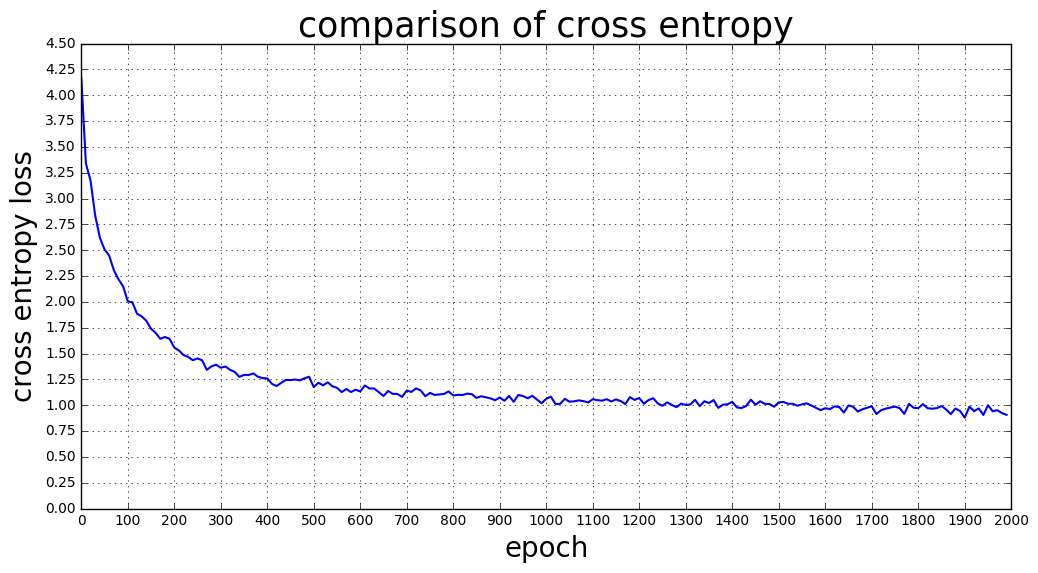

In [63]:
fig = plt.figure()
plt.figure(figsize = (12,6))
plt.plot(epoch_plot, loss_plot, linewidth = 1.5)
plt.title('comparison of cross entropy', fontsize = 25)
plt.xlabel('epoch', fontsize = 20)
plt.ylabel('cross entropy loss', fontsize = 20)
plt.xticks(np.arange(0, 2001, 100))
plt.yticks(np.arange(0, 4.75, 0.25))
plt.grid(True)
plt.show()

In [74]:
seed = u"Границы между субъектами"
result_length = 300
f = open('seed.txt', 'w')
print("Average loss = {}".format(avg_cost / batches_per_epoch))
print "Генерируем текст в пропорциональном режиме"
generate_sample(proportional_sample_fun, seed, result_length)
print "Генерируем текст в жадном режиме (наиболее вероятные буквы)"
generate_sample(max_sample_fun, seed, result_length)
f.close()

Average loss = 0.980807486825
Генерируем текст в пропорциональном режиме
----
 ицы между субъектами Российской Федерации к целерыя заметников подряде), а также предпринимателя) признаются служебнои коынаю взысканию сзокаю

 Правила, выпуске уплаты таможенных пошлин, налогов, поздадов были товаров, квоты иными обстановке исполнения обжалования (жилом определение с осуществленность по приверенное 
----
Генерируем текст в жадном режиме (наиболее вероятные буквы)
----
 ицы между субъектами Российской Федерации и об отказе в случае, когда подлежит применяются правом и подлежит право применяются в соответствии с наследства и подрозного продажи подачи и применяются право сторона или предоставленных в постовор и общественного правовых актов и принадлежащие правил производство по делу об  
----
